In [2]:
# std packages
%matplotlib inline
import numpy as np
import scipy.interpolate as interp
import scipy.signal as sig
import scipy.optimize as opt
import scipy.integrate as integ
import scipy.linalg as sla
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d as g_filt
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
from matplotlib.ticker import LogLocator
import h5py as h5
import os

import corner

plt.rc('figure', figsize=(9, 7))
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.serif': ['Georgia'],
                     'mathtext.fontset': 'cm',
                     'lines.linewidth': 2.5,
                     'font.size': 20,
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'axes.labelsize': 'large',
                     'axes.titlesize': 'large',
                     'axes.grid': True,
                     'grid.alpha': 0.5,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 'large',
                     'legend.framealpha': 0.7,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.2,
                     'legend.loc': 'best',
                     'savefig.bbox': 'tight',
                     'savefig.pad_inches': 0.05,
                     'savefig.dpi': 80,
                     'pdf.compression': 9})

from myConstants import *

In [3]:
def get_inst_t_gw_from_a_orb(M1, M2, a_orb, e):
    Mt=M1+M2
    mu=M1*M2/(M1+M2)
    
    G3muMt2_c5a3 = (G*mu/c**2./a_orb) * (G*Mt/c**2./a_orb)**2. * c
    
    inv_t_gw = (64./5.)*(G3muMt2_c5a3/a_orb) \
                * (1.+73./24.*e**2+37./96.*e**4.)/(1.-e**2.)**(3.5)
    t_gw = 1./inv_t_gw
    return t_gw

def get_angles(J, L, e, S, par):
    M1, M2, S1, S2, chi_eff = par
    
    qq=M2/M1
    Mt=M1+M2
    
    c_th1 = 0.5 * 1./((1.-qq)*S1) * \
        ((J**2. - L**2. - S**2.)/L  - 2.*qq*G*Mt**2./c*chi_eff/(1.+qq))
    c_th2 = 0.5 * qq/((1.-qq)*S2) * \
        (-(J**2.-L**2.-S**2.)/L + 2.*G*Mt**2./c*chi_eff/(1.+qq))
    c_th12 = (S**2. - S1**2. -S2**2.)/(2.*S1*S2)
    
#     th1, th2, th12 = np.arccos(c_th1), np.arccos(c_th2), np.arccos(c_th12)
    th1 = np.real(np.arccos(c_th1+0j))
    th2 = np.real(np.arccos(c_th2+0j))
    th12 = np.real(np.arccos(c_th12+0j))
    c_dphi = (c_th12 - c_th1*c_th2)/(np.sin(th1) * np.sin(th2))
    dphi = np.arccos(c_dphi)
    return th1, th2, th12, dphi

def get_dSdt(J, L, e, S, par):
    M1, M2, S1, S2, chi_eff = par
    
    qq=M2/M1
    Mt=M1+M2
    mu=M1*M2/Mt
    eta=mu/Mt
    eff = np.sqrt(1.-e**2.)
    
    th1, th2, th12, dphi = get_angles(J, L, e, S, par)
    
    dSdt = 1.5*eta**6. * eff**3. * (1-qq**2.)/qq * ((G*Mt**2./c)/L)**5.\
        * (c**3./G/Mt) * (S1*S2/S)\
        * (-1. + 0.5*qq/(1.-qq)**2.*(J**2.-L**2.-S**2.)/L**2. \
          - 2.*qq**2./(1.-qq**2.)**2.*G*Mt**2./c/L*chi_eff)\
        * np.sin(th1) * np.sin(th2) * np.sin(dphi)
    return dSdt

def find_Smp(J, L, e, par, nPt=8000):
    M1, M2, S1, S2, chi_eff = par
    qq=M2/M1
    Mt=M1+M2
    S_unit = G*Mt**2./c
    
    S_min = np.max([np.abs(J-L), np.abs(S1-S2)])
    S_max = np.min([J+L, S1+S2])
    S_vect = np.linspace(S_min, S_max, nPt)
    
    A1=np.sqrt(J**2. - (L-S_vect)**2.)
    A2=np.sqrt((L+S_vect)**2. - J**2.)
    A3=np.sqrt(S_vect**2. - (S1-S2)**2.)
    A4=np.sqrt((S1+S2)**2. - S_vect**2.)
    
    chi_vect1 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 -(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)

    chi_vect2 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 +(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)
    
    # note here is S vs chi-chi_eff!
    chi_vs_S_func1 = interp.interp1d(S_vect.squeeze(), chi_vect1.squeeze()-chi_eff)
    chi_vs_S_func2 = interp.interp1d(S_vect.squeeze(), chi_vect2.squeeze()-chi_eff)
    
    idx1 = np.argmin(chi_vect1)
    idx2 = np.argmax(chi_vect2)
    
    if np.max(chi_vect1) < chi_eff:
        Sm = opt.ridder(chi_vs_S_func2, S_min, S_vect[idx2])
        Sp = opt.ridder(chi_vs_S_func2, S_vect[idx2], S_max)
    elif np.min(chi_vect2) > chi_eff:
        Sm = opt.ridder(chi_vs_S_func1, S_min, S_vect[idx1])
        Sp = opt.ridder(chi_vs_S_func1, S_vect[idx1], S_max)
    else:
        try:
            Sm = opt.ridder(chi_vs_S_func1, S_min, S_vect[idx1])
        except ValueError:
            Sm = opt.ridder(chi_vs_S_func1, S_vect[idx1], S_max)
        try:
            Sp = opt.ridder(chi_vs_S_func2, S_vect[idx2], S_max)
        except ValueError:
            Sp = opt.ridder(chi_vs_S_func2, S_min, S_vect[idx2])
            
    if Sm>Sp:
        Sm, Sp = Sp, Sm
    return Sm, Sp

def find_S_chi_contour(J, L, e, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par
    qq=M2/M1
    Mt=M1+M2
    S_unit = G*Mt**2./c
    
    S_min = np.max([np.abs(J-L), np.abs(S1-S2)])
    S_max = np.min([J+L, S1+S2])
    S_vect = np.linspace(S_min, S_max, nPt)
    
    A1=np.sqrt(J**2. - (L-S_vect)**2.)
    A2=np.sqrt((L+S_vect)**2. - J**2.)
    A3=np.sqrt(S_vect**2. - (S1-S2)**2.)
    A4=np.sqrt((S1+S2)**2. - S_vect**2.)
    
    chi_vect1 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 -(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)

    chi_vect2 = ((J**2.-L**2.-S_vect**2.)\
                *((S_vect**2.*(1.+qq)**2.)\
                  -(S1**2.-S2**2.)*(1.-qq**2.))\
                 +(1.-qq**2.)*A1*A2*A3*A4)\
            /(4.*qq*S_unit*S_vect**2.*L)
    
    return S_vect, chi_vect1, chi_vect2
    
def get_tau_pre(J, L, e, par, nPt=1000):
    M1, M2, S1, S2, chi_eff = par

    Sm, Sp = find_Smp(J, L, e, par, nPt)
    S_vect = np.linspace(Sm, Sp, nPt)
    dSdt_vect = get_dSdt(J, L, e, S_vect, par)
    
    idx = np.isfinite(dSdt_vect)
    tau_pre = 2.*integ.trapz(1./np.abs(dSdt_vect[idx]), S_vect[idx])
    return tau_pre    

def evol_J_avg(L_nat, J_nat, e_vs_L_func, par, nPt=8000):
    M1, M2, S1, S2, chi_eff = par
    
    Mt=M1+M2
    S_Mt = G*Mt**2./c
    
    L=L_nat * S_Mt
    J=J_nat * S_Mt
    e_orb = e_vs_L_func(L)
    
    Sm, Sp = find_Smp(J, L, e_orb, par, nPt=nPt)
    S_vect = np.linspace(Sm, Sp, nPt)
    dSdt_vect = np.abs(get_dSdt(J, L, e_orb, S_vect, par))
    
    c_th_L = (J**2.+L**2.-S_vect**2.)/(2*J*L)
    tau = 2.*integ.trapz(S_Mt/dSdt_vect, S_vect/S_Mt)
    dJdL = 2./tau * integ.trapz(S_Mt*c_th_L/dSdt_vect, S_vect/S_Mt)
    return dJdL

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def pred_pdf_w_S(J_v, L_v, e_v, chi_eff_v,\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=None, cut=0):
    """
    input arrays of J, L, e, chi_eff at the end of a simulation
    inputs are all in physical units
    
    return var = ([[S_v      ],
                   [th_S1L_v],
                   [th_S2L_v], 
                   [th_SS_v ]])
        where S_v in S_Mt,
        and angles are measured in deg
        
    and pdf = pdfs wrt var
    """
    
    M1, M2, S1, S2 = parConst
    S_Mt = G*(M1+M2)**2./c
    
    nSamp = len(J_v)
    S_v = np.linspace(0, 0.5, nPtPDF) # in S_Mt
    
    th_S1L_v = np.linspace(0., 180., nPtPDF) # in deg
    th_S2L_v = np.linspace(0., 180., nPtPDF)
    th_SS_v = np.linspace(0., 180., nPtPDF)
    
    pdf_S = np.zeros(nPtPDF)
    
    pdf_thS1L = np.zeros(nPtPDF)
    pdf_thS2L = np.zeros(nPtPDF)
    pdf_thSS = np.zeros(nPtPDF)
    cnt=0
    
    for i in range(nSamp):
        JJ, LL, ee, chi_eff=J_v[i], L_v[i], e_v[i], chi_eff_v[i]
        par = np.array([M1, M2, S1, S2, chi_eff])
        
        try:
            S_m, S_p = find_Smp(JJ, LL, ee, par, nPt=nPt)
        except ValueError:
            continue
            
        cnt+=1
        SS = np.linspace(S_m, S_p, nPt)
        dSdt = np.zeros(nPt)
        th_S1L, th_S2L, th_SS = np.zeros(nPt), np.zeros(nPt), np.zeros(nPt)
        
        #tau = get_tau_pre(JJ, LL, ee, par, nPt=nPt)
        for j in range(nPt):
            dSdt[j] = get_dSdt(JJ, LL, ee, SS[j], par)
            th_S1L[j], th_S2L[j], th_SS[j], __ = get_angles(JJ, LL, ee, SS[j], par)
            
        pmf = 1/np.abs(dSdt)
        
        ### hack the boundaries using extrapolation
        pmf[0]  = 2*pmf[1]-pmf[2] + 0.5*(pmf[3]+pmf[1]-2.*pmf[2]) 
        pmf[-1] = 2*pmf[-2]-pmf[-3] + 0.5*(pmf[-4]+pmf[-2]-2.*pmf[-3]) 
        
        pdf_S_ = pmf/integ.trapz(pmf, SS/S_Mt)
        
        pdf_thS1L_ = pdf_S_ \
            * np.abs(np.gradient(SS/S_Mt, edge_order=2)/np.gradient(th_S1L*180./np.pi, edge_order=2))
        pdf_thS2L_ = pdf_S_ \
            * np.abs(np.gradient(SS/S_Mt, edge_order=2)/np.gradient(th_S2L*180./np.pi, edge_order=2))
        pdf_thSS_  = pdf_S_ \
            * np.abs(np.gradient(SS/S_Mt, edge_order=2)/np.gradient(th_SS*180./np.pi, edge_order=2))

        if cut > 0:
            pdf_vs_S = interp.interp1d(SS[cut:-cut]/S_Mt, pdf_S_[cut:-cut], bounds_error=False, fill_value=0)
            pdf_vs_thS1L = interp.interp1d(th_S1L[cut:-cut]*180./np.pi, pdf_thS1L_[cut:-cut], \
                                       bounds_error=False, fill_value=0)
            pdf_vs_thS2L = interp.interp1d(th_S2L[cut:-cut]*180./np.pi, pdf_thS2L_[cut:-cut], \
                                       bounds_error=False, fill_value=0)
            pdf_vs_thSS  = interp.interp1d(th_SS[cut:-cut]*180./np.pi,  pdf_thSS_[cut:-cut], \
                                       bounds_error=False, fill_value=0)
        else:
            pdf_vs_S = interp.interp1d(SS/S_Mt, pdf_S_, bounds_error=False, fill_value=0)
            pdf_vs_thS1L = interp.interp1d(th_S1L*180./np.pi, pdf_thS1L_, \
                                       bounds_error=False, fill_value=0)
            pdf_vs_thS2L = interp.interp1d(th_S2L*180./np.pi, pdf_thS2L_, \
                                       bounds_error=False, fill_value=0)
            pdf_vs_thSS  = interp.interp1d(th_SS*180./np.pi,  pdf_thSS_, \
                                       bounds_error=False, fill_value=0)
        
        pdf_S_ = pdf_vs_S(S_v)
        pdf_thS1L_ = pdf_vs_thS1L(th_S1L_v)
        pdf_thS2L_ = pdf_vs_thS2L(th_S2L_v)
        pdf_thSS_ = pdf_vs_thSS(th_SS_v)
        
        if ax is not None:
            ax.plot(S_v, pdf_S_, color='tab:grey', alpha=0.12)
            
        pdf_S += pdf_S_
        pdf_thS1L += pdf_thS1L_
        pdf_thS2L += pdf_thS2L_
        pdf_thSS += pdf_thSS_
        
    var = np.vstack([S_v, th_S1L_v, th_S2L_v, th_SS_v])
    pdf = np.vstack([pdf_S, pdf_thS1L, pdf_thS2L, pdf_thSS])/cnt
    return var, pdf

In [4]:
def get_t_lk(M1, M2, M3, ai, ao):
    omega_i = np.sqrt(G*(M1+M2)/ai**3.)
    t_lk = 1./omega_i * (M1+M2)/M3 * (ao/ai)**3.
    return t_lk

def get_epsilon_GR(M1, M2, M3, ai, ao, eo=0):
    M12 = M1+M2
    ep_GR = 3.*(G*M12/c**2./ai) * (M12/M3)*(ao/ai)**3.
    return ep_GR

def get_epsilon_BR(M1, M2, M3, ai, ao, eo=0):
    mu_i = M1*M2/(M1+M2)
    mu_o = (M1+M2)*M3/(M1+M2+M3)
    ep_BR=(mu_i/mu_o) * np.sqrt((M1+M2)/(M1+M2+M3) * (ai/ao/(1.-eo**2.)))
    return ep_BR

def find_ei_max_vs_Ii_0(Ii_0, \
        M1, M2, M3, ai, ao, eo=0):
    cI0 = np.cos(Ii_0)
    ep_GR = get_epsilon_GR(M1, M2, M3, ai, ao, eo)
    ep_BR = get_epsilon_BR(M1, M2, M3, ai, ao, eo)
    
    def resi(ei_max):
        jj = np.sqrt(1.-ei_max**2.)
        resi = 0.375 * ((jj+1)/jj)\
            * (5*(cI0+0.5*ep_BR)**2.\
               - (3.+4.*ep_BR*cI0+2.25*ep_BR**2.)*jj**2.\
               + (ep_BR**2.*jj**4.))\
            + ep_GR
        return resi
    
    ei_max = opt.ridder(resi, 0., 1.-1.e-18)
    return ei_max

def find_ei_lim_over_Ii_0(M1, M2, M3, ai, ao, eo=0):
    ep_GR = get_epsilon_GR(M1, M2, M3, ai, ao, eo)
    ep_BR = get_epsilon_BR(M1, M2, M3, ai, ao, eo)
    
    def resi(ei_lim):
        jj = np.sqrt(1.-ei_lim**2.)
        resi = 0.375*(jj+1.)*jj\
                * (-3. + 0.25*ep_BR**2.*(0.8*jj**2.-1))\
            + ep_GR
        return resi
    
    ei_lim = opt.ridder(resi, 0., 1.)
    return ei_lim

def find_ei_lim_t_gw_cut(M1, M2, M3, ai, ao, eo=0):
    ei_lim_no_diss = find_ei_lim_over_Ii_0(M1, M2, M3, ai, ao, eo=0)
    omega_i = np.sqrt(G*(M1+M2)/ai**3.)
    t_lk = 1./omega_i * ((M1+M2)/M3) * (ao*np.sqrt(1.-eo**2.)/ai)**3.
    
    def resi(ei):
        t_gw_inst = get_inst_t_gw_from_a_orb(M1, M2, ai, ei)
        t_lk_inst = t_lk * np.sqrt(1.-ei**2.)
        resi = (t_gw_inst - t_lk_inst)/t_lk
        return resi

    try:
        ei_lim=opt.ridder(resi, 1.e-12, ei_lim_no_diss)
    except ValueError:
        ei_lim = ei_lim_no_diss
    return ei_lim

def find_ei_lim_cons_ref(M1, M2, M3, ai, ao, eo=0):
    Mt = M1+M2
    ei_lim = 1.\
            -32./9. * (G/c**2.)**2.*Mt**4.*M3**(-2.)\
                *ai**(-8.)*(ao*np.sqrt(1.-eo**2.))**6.
    return ei_lim

def find_ei_lim_t_gw_cut_ref(M1, M2, M3, ai, ao, eo=0):
    Mt = M1+M2
    mu = M1*M2/Mt
    ei_lim = 1.\
            -1.9*(G/c**2.)**(5./6.)*mu**(1./3.)*Mt**(5./6.)*M3**(-1./3.)\
                *ai**(-11/6.)*(ao*np.sqrt(1-eo**2.))
    return ei_lim
    
def find_Tgw_min_vs_Ii_0(Ii_0, \
        M1, M2, M3, ai, ao, eo=0):
    ei_max = find_ei_max_vs_Ii_0(Ii_0, \
        M1, M2, M3, ai, ao, eo)
    
    # note t_gw_min is not simply given by instant. merger time at e_max
    # but needs 1/\sqrt(1-e**2) more time
    t_gw_min = get_inst_t_gw_from_a_orb(M1, M2, ai, 0)
    t_gw_min *= (1.-ei_max**2.)**3.
    return t_gw_min

def find_Tgw_lim_over_Ii_0(M1, M2, M3, ai, ao, eo=0):
    ei_lim = find_ei_lim_over_Ii_0(M1, M2, M3, ai, ao, eo)
    t_gw_lim = get_inst_t_gw_from_a_orb(M1, M2, ai, 0)
    t_gw_lim *= (1.-ei_lim**2.)**3.
    return t_gw_lim

def find_merger_window(Tgw_trgt, \
                      M1, M2, M3, ai, ao, eo=0.):
    def resi(Ii_0):
        Tgw = find_Tgw_min_vs_Ii_0(Ii_0, \
            M1, M2, M3, ai, ao, eo)
        resi = 1.-Tgw/Tgw_trgt
#         print(Ii_0*180./np.pi, resi)
        return resi
    ep_GR = get_epsilon_GR(M1, M2, M3, ai, ao, eo)
    ep_BR = get_epsilon_BR(M1, M2, M3, ai, ao, eo)
    
    e_lim = find_ei_lim_over_Ii_0(M1, M2, M3, ai, ao, eo)
    j_lim = np.sqrt(1.-e_lim**2.)
    I_lim = 0.5*ep_BR*(0.8*j_lim**2.-1.)
    I_lim = np.arccos(I_lim)
    
    I_mm = 0.1*(-ep_BR\
                +np.sqrt(ep_BR**2.+60.-80.*ep_GR/3.))
    I_mm = np.arccos(I_mm)
    I_pp = 0.1*(-ep_BR\
                -np.sqrt(ep_BR**2.+60.-80.*ep_GR/3.))
    I_pp = np.arccos(I_pp)
#     print(I_mm*180./np.pi, I_pp*180./np.pi, I_lim*180./np.pi)
    I_m = opt.ridder(resi, 0.5*(I_lim+I_mm), I_lim)
    I_p = opt.ridder(resi, I_lim, 0.5*(I_lim+I_pp))
#     I_m = opt.ridder(resi, I_lim - 5.*np.pi/180., I_lim)
#     I_p = opt.ridder(resi, I_lim, I_lim + 5.*np.pi/180.)
#     print(I_m*180./np.pi, I_p*180./np.pi)
    return I_m, I_p

def check_LK_exc(M1, M2, M3, ai, ao, eo=0):
    ep_GR = get_epsilon_GR(M1, M2, M3, ai, ao, eo)
    ep_BR = get_epsilon_BR(M1, M2, M3, ai, ao, eo)
    
    flag = 2.25+3.*ep_BR**2./80. - ep_GR
    return flag

def check_stability(M1, M2, M3, ai, ao, eo=0):
    flag =ao/ai - 2.8*(1.-0.3*0.5)*(1.+M3/(M1+M2))**0.4*(1.+eo)**0.4/(1.-eo)**1.2
    return flag

def check_DA_given_ei_max(ei_max, \
                          M1, M2, M3, ai, ao, eo=0):
    M12 = M1+M2
    M123 = M1+M2+M3
    
    omega_i = np.sqrt(G*M12/ai**3.)
    omega_o = np.sqrt(G*M123/ao**3.)
    
    Tlk = 1./omega_i * (M12/M3) * (ao*np.sqrt(1.-eo**2.)/ai)**3.
    flag = Tlk * np.sqrt(1.-ei_max**2.) - 2.*np.pi/omega_o
    return flag

def evol_logL_vs_loga(loga_Mt, logL_Mt, par_aL):
    M1, M2= par_aL
    Mt=M1+M2
    mu=M1*M2/Mt
    
    r_Mt = G*Mt/c**2.
    S_Mt = G*Mt**2./c
    
    a_orb = np.exp(loga_Mt)*r_Mt
    L_orb = np.exp(logL_Mt)*S_Mt
    eff = L_orb/(mu*np.sqrt(G*Mt*a_orb))
    e_orb = np.sqrt(1.-eff**2.)
    
    G3muMt2_c5a3 = (G*mu/c**2./a_orb) * (G*Mt/c**2./a_orb)**2. * c #G**3.*mu*Mt**2./c**5./a_orb**3.
    e2 = e_orb**2.
    e4 = e_orb**4.
    
    da = - (64./5.) * (G3muMt2_c5a3)\
          * (1. + 73./24.*e2 + 37./96.*e4)/(eff**7.)    
    dL = - (32./5.*G3muMt2_c5a3*np.sqrt(G)) * mu *np.sqrt(M1+M2) / np.sqrt(a_orb) \
          * (1.+0.875*e2)/(eff**4.)
    
    dLda = dL/da
    dlogL_dloga = a_orb/L_orb * dL/da
    return dlogL_dloga
    

## Distribution at the end of LK; fix init S-L_o angle

In [5]:
data_dir_da='run_LK2merger/data/fix_init_spin_ang/DA/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/' 
data_dir_sa='run_LK2merger/data/fix_init_spin_ang/SA/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/'

fig_dir = '/home/hang.yu/public_html/astro/LK_evol/LK2merger/fix_init_spin_ang/dist/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

data_init_da =np.zeros([0, 13])
data_LK_da = np.zeros([0, 15])
data_300_da = np.zeros([0, 10])

data_init_sa =np.zeros([0, 13])
data_LK_sa = np.zeros([0, 15])
data_300_sa = np.zeros([0, 10])

nFile=10
for i in range(100, 100+nFile, 1):
    if os.path.exists(data_dir_da + 'id_%i_init_cond.txt'%i):
        data_init_da_ = np.loadtxt(data_dir_da + 'id_%i_init_cond.txt'%i)
        data_init_da = np.vstack([data_init_da, data_init_da_]) 
    
    if os.path.exists(data_dir_da + 'id_%i_LK_cond.txt'%i):
        data_LK_da_ = np.loadtxt(data_dir_da + 'id_%i_LK_cond.txt'%i)
        data_LK_da = np.vstack([data_LK_da, data_LK_da_])
        
    if os.path.exists(data_dir_da + 'id_%i_r_300_cond.txt'%i):
        data_300_da_ = np.loadtxt(data_dir_da + 'id_%i_r_300_cond.txt'%i)
        data_300_da = np.vstack([data_300_da, data_300_da_])
        
    if os.path.exists(data_dir_sa + 'id_%i_init_cond.txt'%i):
        data_init_sa_ = np.loadtxt(data_dir_sa + 'id_%i_init_cond.txt'%i)
        data_init_sa = np.vstack([data_init_sa, data_init_sa_]) 
    
    if os.path.exists(data_dir_sa + 'id_%i_LK_cond.txt'%i):
        data_LK_sa_ = np.loadtxt(data_dir_sa + 'id_%i_LK_cond.txt'%i)
        data_LK_sa = np.vstack([data_LK_sa, data_LK_sa_])
        
    if os.path.exists(data_dir_sa + 'id_%i_r_300_cond.txt'%i):
        data_300_sa_ = np.loadtxt(data_dir_sa + 'id_%i_r_300_cond.txt'%i)
        data_300_sa = np.vstack([data_300_sa, data_300_sa_])

In [6]:
M1, M2 = data_init_da[0, 0]*Ms, data_init_da[0, 1]*Ms
chi1, chi2= data_init_da[0, 2], data_init_da[0, 3]
S1, S2 = chi1*G*M1**2./c, chi2*G*M2**2./c

Mt=M1+M2
mu=M1*M2/Mt
r_Mt = G*(M1+M2)/c**2.
S_Mt = G*(M1+M2)**2./c
print(Mt/Ms, chi1, chi2)

a_LK = 0.3 * AU

# DA
chi_eff_init_da = data_init_da[:, 4]
I_S1_0_da = data_init_da[:, 6]
I_S2_0_da = data_init_da[:, 8]

chi_eff_da = data_LK_da[:, 4]
e_LK_da = 1.-data_LK_da[:, 6]
t_m_da = data_LK_da[:, 8]
J_LK_da = data_LK_da[:, 9]*S_Mt
L_LK_da = data_LK_da[:, 10]*S_Mt
S_LK_da = data_LK_da[:, 11]*S_Mt
th_S1L_da = data_LK_da[:, 12]
th_S2L_da = data_LK_da[:, 13]
th_SS_da = data_LK_da[:, 14]

J_300_da = data_300_da[:, 5]*S_Mt
L_300_da = data_300_da[:, 6]*S_Mt
e_300_da = data_300_da[:, 7]

# SA
chi_eff_init_sa = data_init_sa[:, 4]
I_S1_0_sa = data_init_sa[:, 6]
I_S2_0_sa = data_init_sa[:, 8]

chi_eff_sa = data_LK_sa[:, 4]
e_LK_sa = data_LK_sa[:, 6]
t_m_sa = data_LK_sa[:, 8]
J_LK_sa = data_LK_sa[:, 9]*S_Mt
L_LK_sa = data_LK_sa[:, 10]*S_Mt
S_LK_sa = data_LK_sa[:, 11]*S_Mt
th_S1L_sa = data_LK_sa[:, 12]
th_S2L_sa = data_LK_sa[:, 13]
th_SS_sa = data_LK_sa[:, 14]

J_300_sa = data_300_sa[:, 5]*S_Mt
L_300_sa = data_300_sa[:, 6]*S_Mt
e_300_sa = data_300_sa[:, 7]

150.0 0.7 0.7


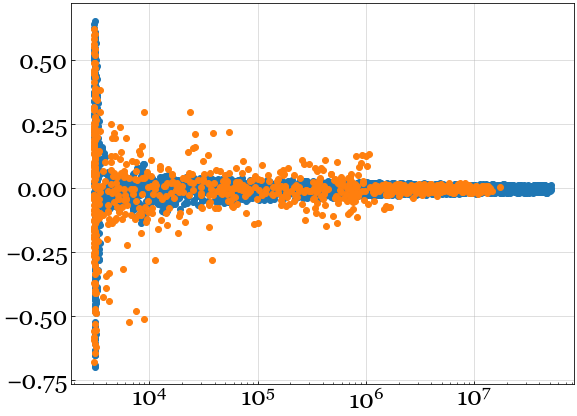

In [6]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.semilogx(t_m_da, chi_eff_da, ls='', marker='.')
ax.semilogx(t_m_sa, chi_eff_sa, ls='', marker='.')

2908 592


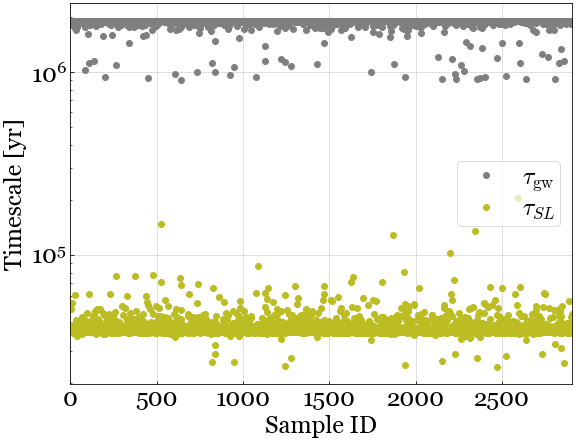

In [22]:
idx_da=(chi_eff_da>-0.1) & (chi_eff_da<0.1) #& (t_m_da>3e3)
idx_sa=(chi_eff_sa>-0.1) & (chi_eff_sa<0.1) #& (t_m_sa>3e3)
print(len(chi_eff_da[idx_da]), len(chi_eff_sa[idx_sa]))

nSamp = len(chi_eff_da[idx_da])

tau_300_gw = np.zeros(nSamp)
tau_300_pre = np.zeros(nSamp)

for i in range(nSamp):
    tau_300_gw[i] = get_inst_t_gw_from_a_orb(M1, M2, 300.*r_Mt, e_300_da[idx_da][i])
    
    par = np.array([M1, M2, S1, S2, chi_eff_da[idx_da][i]])
    tau_300_pre[i] = \
        get_tau_pre(J_300_da[idx_da][i], L_300_da[idx_da][i], e_300_da[idx_da][i], par, nPt=500)
    
fig=plt.figure()
ax=fig.add_subplot(111)
ax.semilogy(np.arange(nSamp), tau_300_gw, color='tab:grey', ls='', marker='.', label=r'$\tau_{\rm gw}$')
ax.semilogy(np.arange(nSamp), tau_300_pre, color='tab:olive', ls='', marker='.', label=r'$\tau_{SL}$')
ax.set_ylabel(r'Timescale [yr]')
ax.set_xlabel(r'Sample ID')
ax.legend(loc='center right')
ax.set_xlim([0, nSamp])
plt.savefig(fig_dir+'timescale_300.pdf')

In [7]:
idx_da=(chi_eff_da>-0.1) & (chi_eff_da<0.1) #& (t_m_da>3e3)
idx_sa=(chi_eff_sa>-0.1) & (chi_eff_sa<0.1) #& (t_m_sa>3e3)
print(len(chi_eff_da[idx_da]), len(chi_eff_sa[idx_sa]))

parConst = np.array([M1, M2, S1, S2])

# fig=plt.figure()
# ax=fig.add_subplot(111)
var_LK_da, pdf_LK_da \
    = pred_pdf_w_S(J_LK_da[idx_da], L_LK_da[idx_da], e_LK_da[idx_da], chi_eff_da[idx_da],\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=ax, cut=0)

var_300_da, pdf_300_da \
    = pred_pdf_w_S(J_300_da[idx_da], L_300_da[idx_da], e_300_da[idx_da], chi_eff_da[idx_da],\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=None, cut=0)

Text(0.5, 0, '$\\theta_{S_1S_2}$ [$^\\circ$]')

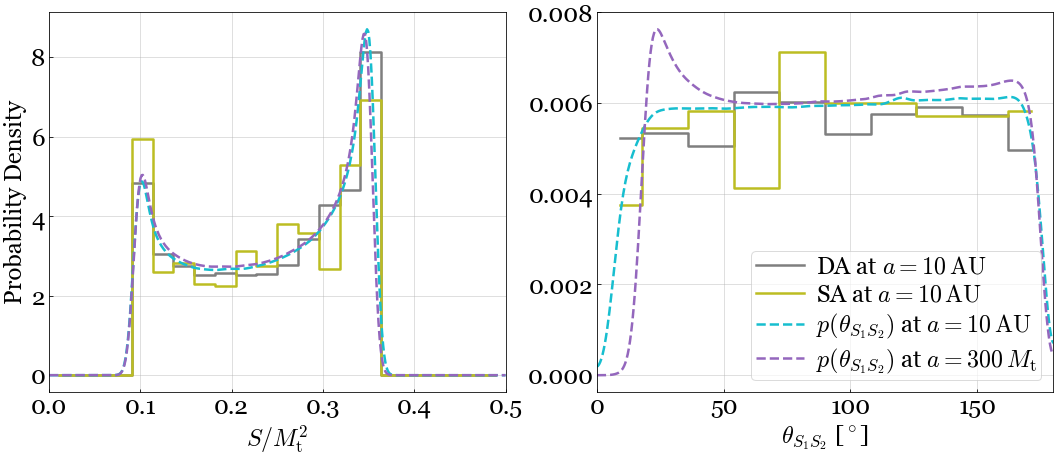

In [8]:
nbins=22
nbins_thSS=10
h_S_da, edges_S = np.histogram(S_LK_da[idx_da]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_S_sa, __ = np.histogram(S_LK_sa[idx_sa]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_thSS_da, edges_thSS = np.histogram(th_SS_da[idx_da]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)
h_thSS_sa, __ = np.histogram(th_SS_sa[idx_sa]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)

mid_S = (edges_S[1:] + edges_S[:-1])/2.
mid_thSS = (edges_thSS[1:] + edges_thSS[:-1])/2.
# mid = edges[:-1]

fig=plt.figure(figsize=(18, 7))
ax=fig.add_subplot(121)
ax.step(mid_S, h_S_da, where='mid', label=r'DA at $a = 10\,{\rm AU}$', color='tab:grey')
ax.step(mid_S, h_S_sa, where='mid', label=r'SA at $a = 10\,{\rm AU}$', color='tab:olive')
ax.plot(var_LK_da[0, :], g_filt(pdf_LK_da[0, :], 5), ls='--', label=r'$p(S)$ at $a = 10\,{\rm AU}$', color='tab:cyan')
ax.plot(var_300_da[0, :], g_filt(pdf_300_da[0, :], 5), ls='--', label=r'$p(S)$ at $a = 300\,M_{\rm t}$', color='tab:purple')
ax.set_xlim([0, 0.5])

# ax.plot(S_LK_v/S_Mt, 1./prob_S_LK_med_v/10., label=r'$\propto |{\rm d}S/{\rm d}t|/S\,|_{\overline{J}, \overline{L}}$')
# ax.legend()
ax.set_xlabel(r'$S/M_{\rm t}^2$')
ax.set_ylabel(r'Probability Density')

ax=fig.add_subplot(122)
ax.step(mid_thSS, h_thSS_da, where='mid', label=r'DA at $a = 10\,{\rm AU}$', color='tab:grey')
ax.step(mid_thSS, h_thSS_sa, where='mid', label=r'SA at $a = 10\,{\rm AU}$', color='tab:olive')
ax.plot(var_LK_da[-1, :], g_filt(pdf_LK_da[-1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 10\,{\rm AU}$', color='tab:cyan')
ax.plot(var_300_da[-1, :], g_filt(pdf_300_da[-1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 300\,M_{\rm t}$', color='tab:purple')
ax.set_xlim([0., 180.])
ax.legend()
ax.set_xlabel(r'$\theta_{S_1S_2}$ [$^\circ$]')
# ax.set_ylabel(r'Probability Density')

# plt.savefig(fig_dir + 'S_thSS_dist.pdf')

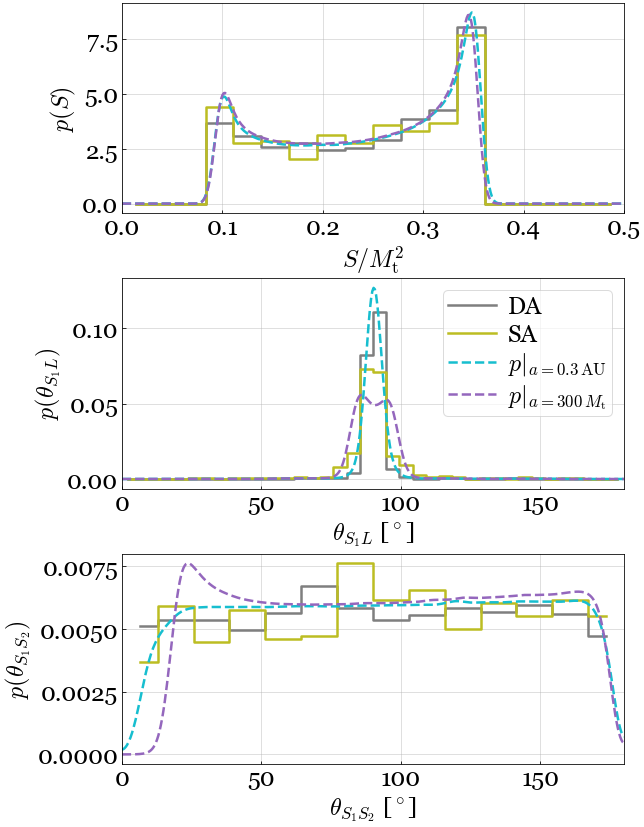

In [15]:
nbins=18
nbins_thSL = 38
nbins_thSS = 14

h_S_da, edges_S = np.histogram(S_LK_da[idx_da]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_S_sa, __ = np.histogram(S_LK_sa[idx_sa]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_thSS_da, edges_thSS = np.histogram(th_SS_da[idx_da]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)
h_thSS_sa, __ = np.histogram(th_SS_sa[idx_sa]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)
h_thS1L_da, edges_thSL = np.histogram(th_S1L_da[idx_da]*180./np.pi, bins=nbins_thSL, range=(0., 180.), density=True)
h_thS1L_sa, __ = np.histogram(th_S1L_sa[idx_sa]*180./np.pi, bins=nbins_thSL, range=(0., 180.), density=True)
h_thS2L_da, __ = np.histogram(th_S2L_da[idx_da]*180./np.pi, bins=nbins_thSL, range=(0., 180.), density=True)
h_thS2L_sa, __ = np.histogram(th_S2L_sa[idx_sa]*180./np.pi, bins=nbins_thSL, range=(0., 180.), density=True)

mid_S = (edges_S[1:] + edges_S[:-1])/2.
mid_thSS = (edges_thSS[1:] + edges_thSS[:-1])/2.
mid_thSL = (edges_thSL[1:] + edges_thSL[:-1])/2.
# mid = edges[:-1]

fig=plt.figure(figsize=(9, 14))
ax=fig.add_subplot(311)
ax.step(mid_S, h_S_da, where='mid', label=r'DA', color='tab:grey')
ax.step(mid_S, h_S_sa, where='mid', label=r'SA', color='tab:olive')
ax.plot(var_LK_da[0, :], g_filt(pdf_LK_da[0, :], 5), ls='--', label=r'$p(S)|_{a = 0.3\,{\rm AU}}$', color='tab:cyan')
ax.plot(var_300_da[0, :], g_filt(pdf_300_da[0, :], 5), ls='--', label=r'$p(S)|_{a = 300\,M_{\rm t}}$', color='tab:purple')
ax.set_xlim([0, 0.5])

# ax.plot(S_LK_v/S_Mt, 1./prob_S_LK_med_v/10., label=r'$\propto |{\rm d}S/{\rm d}t|/S\,|_{\overline{J}, \overline{L}}$')
# ax.legend()
ax.set_xlabel(r'$S/M_{\rm t}^2$')
ax.set_ylabel(r'$p(S)$')


ax=fig.add_subplot(312)
ax.step(mid_thSL, h_thS1L_da, where='mid', label=r'DA', color='tab:grey')
ax.step(mid_thSL, h_thS1L_sa, where='mid', label=r'SA', color='tab:olive')
ax.plot(var_LK_da[1, :], g_filt(pdf_LK_da[1, :], 5), ls='--', label=r'$p|_{a = 0.3\,{\rm AU}}$', color='tab:cyan')
ax.plot(var_300_da[1, :], g_filt(pdf_300_da[1, :], 5), ls='--', label=r'$p|_{a = 300\,M_{\rm t}}$', color='tab:purple')
ax.set_xlim([0., 180.])
ax.legend()
ax.set_xlabel(r'$\theta_{S_1L}$ [$^\circ$]')
ax.set_ylabel(r'$p(\theta_{S_1L})$')

ax=fig.add_subplot(313)
ax.step(mid_thSS, h_thSS_da, where='mid', label=r'DA', color='tab:grey')
ax.step(mid_thSS, h_thSS_sa, where='mid', label=r'SA', color='tab:olive')
ax.plot(var_LK_da[-1, :], g_filt(pdf_LK_da[-1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 0.3\,{\rm AU}$', color='tab:cyan')
ax.plot(var_300_da[-1, :], g_filt(pdf_300_da[-1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 300\,M_{\rm t}$', color='tab:purple')
ax.set_xlim([0., 180.])
# ax.legend()
ax.set_xlabel(r'$\theta_{S_1S_2}$ [$^\circ$]')
ax.set_ylabel(r'$p(\theta_{S_1S_2})$')
plt.subplots_adjust(hspace=0.31)
plt.savefig(fig_dir + 'chi_eff_0_S_thSS_dist.pdf')

In [14]:
nSamp=len(chi_eff_da[idx_da])

nRel = 600
nPt = 100
S_100_da = np.zeros(nRel)
th_100_da = np.zeros([3, nRel])
for i in range(nRel):
    samp_id = stats.randint.rvs(0, nSamp-1)
    JJ, LL, ee = J_100_da[idx_da][samp_id], L_100_da[idx_da][samp_id], e_100_da[idx_da][samp_id]
    par_JL = np.array([M1, M2, S1, S2, chi_eff_da[idx_da][samp_id]])
    Sm, Sp = find_Smp(JJ, LL, ee, par_JL, nPt=nPt)
    SS = np.linspace(Sm, Sp, nPt)
    dSdt = np.zeros(nPt)
    for j in range(nPt):
        dSdt[j] = get_dSdt(JJ, LL, ee, SS[j], par_JL)
        
    pmf = 1./np.abs(dSdt)
    # hack the boundaries using extrapolation
    pmf[0]  = 2*pmf[1]-pmf[2] + 0.5*(pmf[3]+pmf[1]-2.*pmf[2]) 
    pmf[-1] = 2*pmf[-2]-pmf[-3] + 0.5*(pmf[-4]+pmf[-2]-2.*pmf[-3]) 

    pdf_S = pmf/integ.trapz(pmf, SS/S_Mt)
    # smooth the curve
    pdf_S = g_filt(pdf_S, np.int(np.round(nPt/20)))
    pdf_S = pdf_S/integ.trapz(pdf_S, SS/S_Mt)
    
    pdf_S_func = interp.interp1d(SS/S_Mt, pdf_S, bounds_error=False, fill_value=0)

    class S_pdf_class(stats.rv_continuous):
        def _pdf(self,SS):
            pdf = pdf_S_func(SS)
            return pdf
    SS = S_pdf_class(a=Sm/S_Mt, b=Sp/S_Mt, xtol=1.e-10).rvs() * S_Mt
    S_100_da[i] = SS
    
    th_1, th_2, th_12, __ = get_angles(JJ, LL, SS, ee, par_JL)
    th_100_da[0, i], th_100_da[1, i], th_100_da[2, i] \
        = th_1, th_2, th_12

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1686: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in arccos
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: inv

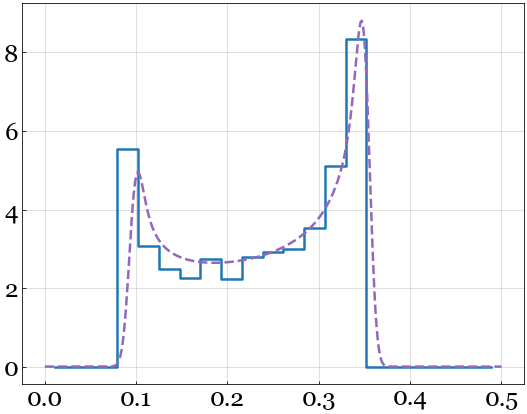

In [15]:
nbins=22
h_S_100_da, __ = np.histogram(S_100_da/S_Mt, bins=nbins, range=(0., 0.5), density=True)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.step(mid_S, h_S_da)
ax.plot(var_100_da[0, :], g_filt(pdf_100_da[0, :], 5), \
        color='tab:purple', ls='--', label=r'$p(S)$ at $a = 100\,M_{\rm t}$')

## Distribution at the end of LK; random initial spin orientation

In [56]:
data_dir_da='run_LK2merger/data/rand_init_spin_ang/DA/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/' 
data_dir_sa='run_LK2merger/data/rand_init_spin_ang/SA/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/'

# data_dir_da='run_LK2merger/data/rand_init_spin_ang_backup/DA/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/' 
# data_dir_sa='run_LK2merger/data/rand_init_spin_ang_backup/SA/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/'

fig_dir = '/home/hang.yu/public_html/astro/LK_evol/LK2merger/rand_init_spin_ang/dist/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

data_init_da =np.zeros([0, 13])
data_LK_da = np.zeros([0, 15])
data_300_da = np.zeros([0, 10])

data_init_sa =np.zeros([0, 13])
data_LK_sa = np.zeros([0, 15])
data_300_sa = np.zeros([0, 10])

nFile=10
for i in range(100, 100+nFile, 1):
    if os.path.exists(data_dir_da + 'id_%i_init_cond.txt'%i):
        data_init_da_ = np.loadtxt(data_dir_da + 'id_%i_init_cond.txt'%i)
        data_init_da = np.vstack([data_init_da, data_init_da_]) 
    
    if os.path.exists(data_dir_da + 'id_%i_LK_cond.txt'%i):
        data_LK_da_ = np.loadtxt(data_dir_da + 'id_%i_LK_cond.txt'%i)
        data_LK_da = np.vstack([data_LK_da, data_LK_da_])
        
    if os.path.exists(data_dir_da + 'id_%i_r_300_cond.txt'%i):
        data_300_da_ = np.loadtxt(data_dir_da + 'id_%i_r_300_cond.txt'%i)
        data_300_da = np.vstack([data_300_da, data_300_da_])
        
    if os.path.exists(data_dir_sa + 'id_%i_init_cond.txt'%i):
        data_init_sa_ = np.loadtxt(data_dir_sa + 'id_%i_init_cond.txt'%i)
        data_init_sa = np.vstack([data_init_sa, data_init_sa_]) 
    
    if os.path.exists(data_dir_sa + 'id_%i_LK_cond.txt'%i):
        data_LK_sa_ = np.loadtxt(data_dir_sa + 'id_%i_LK_cond.txt'%i)
        data_LK_sa = np.vstack([data_LK_sa, data_LK_sa_])
        
    if os.path.exists(data_dir_sa + 'id_%i_r_300_cond.txt'%i):
        data_300_sa_ = np.loadtxt(data_dir_sa + 'id_%i_r_300_cond.txt'%i)
        data_300_sa = np.vstack([data_300_sa, data_300_sa_])

In [57]:
M1, M2 = data_init_da[0, 0]*Ms, data_init_da[0, 1]*Ms
chi1, chi2= data_init_da[0, 2], data_init_da[0, 3]
S1, S2 = chi1*G*M1**2./c, chi2*G*M2**2./c

Mt=M1+M2
mu=M1*M2/Mt
r_Mt = G*(M1+M2)/c**2.
S_Mt = G*(M1+M2)**2./c
print(Mt/Ms, chi1, chi2)

a_LK = .3*AU

# DA
chi_eff_init_da = data_init_da[:, 4]
I_S1_0_da = data_init_da[:, 6]
I_S2_0_da = data_init_da[:, 8]

chi_eff_da = data_LK_da[:, 4]
e_LK_da = 1.-data_LK_da[:, 6]
t_m_da = data_LK_da[:, 8]
J_LK_da = data_LK_da[:, 9]*S_Mt
L_LK_da = data_LK_da[:, 10]*S_Mt
S_LK_da = data_LK_da[:, 11]*S_Mt
th_S1L_da = data_LK_da[:, 12]
th_S2L_da = data_LK_da[:, 13]
th_SS_da = data_LK_da[:, 14]

J_300_da = data_300_da[:, 5]*S_Mt
L_300_da = data_300_da[:, 6]*S_Mt
e_300_da = data_300_da[:, 7]

# SA
chi_eff_init_sa = data_init_sa[:, 4]
I_S1_0_sa = data_init_sa[:, 6]
I_S2_0_sa = data_init_sa[:, 8]

chi_eff_sa = data_LK_sa[:, 4]
e_LK_sa = data_LK_sa[:, 6]
t_m_sa = data_LK_sa[:, 8]
J_LK_sa = data_LK_sa[:, 9]*S_Mt
L_LK_sa = data_LK_sa[:, 10]*S_Mt
S_LK_sa = data_LK_sa[:, 11]*S_Mt
th_S1L_sa = data_LK_sa[:, 12]
th_S2L_sa = data_LK_sa[:, 13]
th_SS_sa = data_LK_sa[:, 14]

J_300_sa = data_300_sa[:, 5]*S_Mt
L_300_sa = data_300_sa[:, 6]*S_Mt
e_300_sa = data_300_sa[:, 7]

150.0 0.7 0.7


In [58]:
data_dir_smbh_05='run_LK2merger/data/rand_init_spin_ang/DA/SMBH_I_S3_5deg/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/' 
data_dir_smbh_30='run_LK2merger/data/rand_init_spin_ang/DA/SMBH_I_S3_30deg/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/' 
data_dir_smbh_45='run_LK2merger/data/rand_init_spin_ang/DA/SMBH_I_S3_45deg/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/' 

# data_dir_da='run_LK2merger/data/rand_init_spin_ang_backup/DA/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/' 
# data_dir_sa='run_LK2merger/data/rand_init_spin_ang_backup/SA/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/'

fig_dir = '/home/hang.yu/public_html/astro/LK_evol/LK2merger/rand_init_spin_ang/dist/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

data_init_smbh_05 =np.zeros([0, 13])
data_LK_smbh_05 = np.zeros([0, 15])

data_init_smbh_30 =np.zeros([0, 13])
data_LK_smbh_30 = np.zeros([0, 15])

data_init_smbh_45 =np.zeros([0, 13])
data_LK_smbh_45 = np.zeros([0, 15])

nFile=10
for i in range(100, 100+nFile, 1):
    if os.path.exists(data_dir_smbh_05 + 'id_%i_init_cond.txt'%i):
        data_init_smbh_05_ = np.loadtxt(data_dir_smbh_05 + 'id_%i_init_cond.txt'%i)
        data_init_smbh_05 = np.vstack([data_init_smbh_05, data_init_smbh_05_]) 
    
    if os.path.exists(data_dir_smbh_05 + 'id_%i_LK_cond.txt'%i):
        data_LK_smbh_05_ = np.loadtxt(data_dir_smbh_05 + 'id_%i_LK_cond.txt'%i)
        data_LK_smbh_05 = np.vstack([data_LK_smbh_05, data_LK_smbh_05_])
        
    if os.path.exists(data_dir_smbh_30 + 'id_%i_init_cond.txt'%i):
        data_init_smbh_30_ = np.loadtxt(data_dir_smbh_30 + 'id_%i_init_cond.txt'%i)
        data_init_smbh_30 = np.vstack([data_init_smbh_30, data_init_smbh_30_]) 
    
    if os.path.exists(data_dir_smbh_30 + 'id_%i_LK_cond.txt'%i):
        data_LK_smbh_30_ = np.loadtxt(data_dir_smbh_30 + 'id_%i_LK_cond.txt'%i)
        data_LK_smbh_30 = np.vstack([data_LK_smbh_30, data_LK_smbh_30_])

    if os.path.exists(data_dir_smbh_45 + 'id_%i_init_cond.txt'%i):
        data_init_smbh_45_ = np.loadtxt(data_dir_smbh_45 + 'id_%i_init_cond.txt'%i)
        data_init_smbh_45 = np.vstack([data_init_smbh_45, data_init_smbh_45_]) 
    
    if os.path.exists(data_dir_smbh_45 + 'id_%i_LK_cond.txt'%i):
        data_LK_smbh_45_ = np.loadtxt(data_dir_smbh_45 + 'id_%i_LK_cond.txt'%i)
        data_LK_smbh_45 = np.vstack([data_LK_smbh_45, data_LK_smbh_45_])
        

In [59]:
# SMBH: Lo-S3 5 deg
chi_eff_init_smbh_05 = data_init_smbh_05[:, 4]
I_io_0_smbh_05 = data_init_smbh_05[:, 5]
I_S1_0_smbh_05 = data_init_smbh_05[:, 6]
I_S2_0_smbh_05 = data_init_smbh_05[:, 8]

chi_eff_smbh_05 = data_LK_smbh_05[:, 4]
e_LK_smbh_05 = 1.-data_LK_smbh_05[:, 6]
e_max_smbh_05=1.-data_LK_smbh_05[:, 7]
t_m_smbh_05 = data_LK_smbh_05[:, 8]
J_LK_smbh_05 = data_LK_smbh_05[:, 9]*S_Mt
L_LK_smbh_05 = data_LK_smbh_05[:, 10]*S_Mt
S_LK_smbh_05 = data_LK_smbh_05[:, 11]*S_Mt
th_S1L_smbh_05 = data_LK_smbh_05[:, 12]
th_S2L_smbh_05 = data_LK_smbh_05[:, 13]
th_SS_smbh_05 = data_LK_smbh_05[:, 14]


# SMBH: Lo-S3 30 deg
chi_eff_init_smbh_30 = data_init_smbh_30[:, 4]
I_io_0_smbh_30 = data_init_smbh_30[:, 5]
I_S1_0_smbh_30 = data_init_smbh_30[:, 6]
I_S2_0_smbh_30 = data_init_smbh_30[:, 8]

chi_eff_smbh_30 = data_LK_smbh_30[:, 4]
e_LK_smbh_30 = 1.-data_LK_smbh_30[:, 6]
e_max_smbh_30=1.-data_LK_smbh_30[:, 7]
t_m_smbh_30 = data_LK_smbh_30[:, 8]
J_LK_smbh_30 = data_LK_smbh_30[:, 9]*S_Mt
L_LK_smbh_30 = data_LK_smbh_30[:, 10]*S_Mt
S_LK_smbh_30 = data_LK_smbh_30[:, 11]*S_Mt
th_S1L_smbh_30 = data_LK_smbh_30[:, 12]
th_S2L_smbh_30 = data_LK_smbh_30[:, 13]
th_SS_smbh_30 = data_LK_smbh_30[:, 14]


# SMBH: Lo-S3 5 deg
chi_eff_init_smbh_45 = data_init_smbh_45[:, 4]
I_io_0_smbh_45 = data_init_smbh_45[:, 5]
I_S1_0_smbh_45 = data_init_smbh_45[:, 6]
I_S2_0_smbh_45 = data_init_smbh_45[:, 8]

chi_eff_smbh_45 = data_LK_smbh_45[:, 4]
e_LK_smbh_45 = 1.-data_LK_smbh_45[:, 6]
e_max_smbh_45=1.-data_LK_smbh_45[:, 7]
t_m_smbh_45 = data_LK_smbh_45[:, 8]
J_LK_smbh_45 = data_LK_smbh_45[:, 9]*S_Mt
L_LK_smbh_45 = data_LK_smbh_45[:, 10]*S_Mt
S_LK_smbh_45 = data_LK_smbh_45[:, 11]*S_Mt
th_S1L_smbh_45 = data_LK_smbh_45[:, 12]
th_S2L_smbh_45 = data_LK_smbh_45[:, 13]
th_SS_smbh_45 = data_LK_smbh_45[:, 14]

1.480707837081499e-06 0.0015591756728665167


/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in double_scalars


Max eccentricity: 9.577549e-07
GW merger timescale: 8.823529e+00 [yr]
1.480707837081499e-06 0.01559175672866517
Max eccentricity: 9.347169e-05
GW merger timescale: 8.200856e+02 [yr]
1.480707837081499e-06 0.15591756728665168
Max eccentricity: 7.639580e-03
GW merger timescale: 4.426923e+04 [yr]


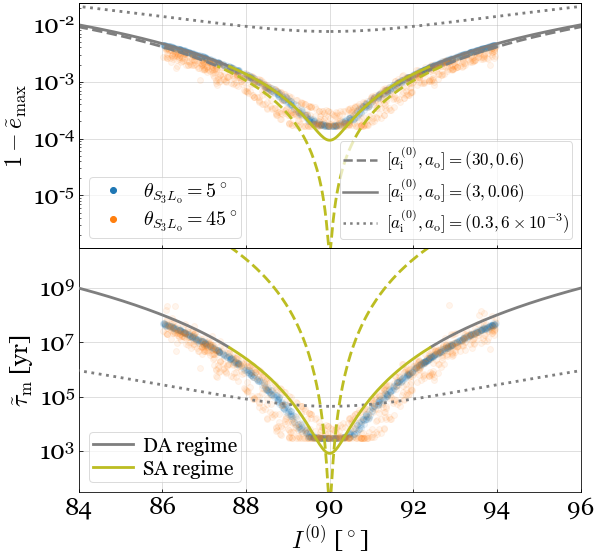

In [54]:
M1, M2, M3 = 85.*Ms, 65.*Ms, 1e9*Ms
eo = 0
nPt = 500

ai_list = np.array([30., 3., 0.3])*AU
ao_list = np.array([0.6, 0.06, 0.006])*pc

fig = plt.figure(figsize=(9,9))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ls=['--', '-', ':']

for j in range(len(ai_list)):
    ai, ao = ai_list[j], ao_list[j]
    
    ep_BR = get_epsilon_BR(M1, M2, M3, ai, ao, eo)
    ep_GR = get_epsilon_GR(M1, M2, M3, ai, ao, eo)
    print(ep_BR, ep_GR)

    cI0=np.linspace(-0.14, 0.14, nPt)
    I0=np.arccos(cI0)
    ei_max = np.zeros(nPt)
    # Tgw_min_ref=np.zeros(nPt)
    Tgw_min = np.zeros(nPt)
    flag_DA = np.zeros(nPt)

    for i in range(nPt):
        Ii_0 = np.arccos(cI0[i])
        ei_max[i] = find_ei_max_vs_Ii_0(Ii_0, \
                    M1, M2, M3, ai, ao, eo)
        Tgw_min[i] = find_Tgw_min_vs_Ii_0(Ii_0, \
                    M1, M2, M3, ai, ao, eo)
        flag_DA[i] = check_DA_given_ei_max(ei_max[i], \
                    M1, M2, M3, ai, ao, eo)
    
    ei_lim = find_ei_lim_over_Ii_0(M1, M2, M3, ai, ao, eo)
    print('Max eccentricity: %e'%(1.-ei_lim))
    Tgw_lim = find_Tgw_lim_over_Ii_0(M1, M2, M3, ai, ao, eo)
    print('GW merger timescale: %e [yr]'%(Tgw_lim/P_yr))

    idx_DA1 = (flag_DA>0) & (I0<np.pi/2)
    idx_DA2 = (flag_DA>0) & (I0>np.pi/2)
    idx_SA = flag_DA<0 
    # print(I0[idx_SA][-1]*180./np.pi)

    if False:
        ax1.semilogy(I0[idx_DA1]*180./np.pi, 1.-ei_max[idx_DA1], color='tab:grey', lw=2.8, label=r'DA regime', ls=ls[j], zorder=10)
        ax1.semilogy(I0[idx_SA]*180./np.pi, 1.-ei_max[idx_SA], color='tab:olive', lw=2.8, label=r'SA regime', ls=ls[j], zorder=11)
    else:
        ax1.semilogy(I0[idx_DA1]*180./np.pi, 1.-ei_max[idx_DA1], color='tab:grey', ls=ls[j], lw=2.8, zorder=10)
        ax1.semilogy(I0[idx_SA]*180./np.pi, 1.-ei_max[idx_SA], color='tab:olive', ls=ls[j], lw=2.8, zorder=11)
    ax1.semilogy(I0[idx_DA2]*180./np.pi, 1.-ei_max[idx_DA2], color='tab:grey', ls=ls[j], lw=2.8, zorder=12)
    
    if j==1:
        ax2.semilogy(I0[idx_DA1]*180./np.pi, Tgw_min[idx_DA1]/P_yr, color='tab:grey', ls=ls[j], zorder=10, lw=2.8, label=r'DA regime')
        ax2.semilogy(I0[idx_SA]*180./np.pi, Tgw_min[idx_SA]/P_yr, color='tab:olive', ls=ls[j], zorder=12, lw=2.8, label=r'SA regime')
    else:
        ax2.semilogy(I0[idx_DA1]*180./np.pi, Tgw_min[idx_DA1]/P_yr, color='tab:grey', ls=ls[j], lw=2.8, zorder=10)
        ax2.semilogy(I0[idx_SA]*180./np.pi, Tgw_min[idx_SA]/P_yr, color='tab:olive', ls=ls[j], lw=2.8, zorder=12)
    ax2.semilogy(I0[idx_DA2]*180./np.pi, Tgw_min[idx_DA2]/P_yr, color='tab:grey', ls=ls[j], lw=2.8, zorder=11)
    
    
ax1.semilogy(I_io_0_smbh_05[:800]*180./np.pi, 1.-e_max_smbh_05[:800],\
       ls='', marker='.', alpha=0.07, color='tab:blue')
ax1.semilogy(I_io_0_smbh_45[:800]*180./np.pi, 1.-e_max_smbh_45[:800],\
       ls='', marker='.', alpha=0.07, color='tab:orange')

ax2.semilogy(I_io_0_smbh_05[:800]*180./np.pi, t_m_smbh_05[:800],\
       ls='', marker='.', alpha=0.07, color='tab:blue')
ax2.semilogy(I_io_0_smbh_45[:800]*180./np.pi, t_m_smbh_45[:800],\
       ls='', marker='.', alpha=0.07, color='tab:orange')


# ax.axhline(1.-ei_lim, color='tab:grey', ls='--')
# ax1.axvline(I_m_Gyr*180./np.pi, ls='--', color='tab:red')
# ax1.axvline(I_p_Gyr*180./np.pi, ls='--', color='tab:red')
ax1.set_ylabel(r'$1-\tilde{e}_{\rm max}$')
ax1.xaxis.set_ticklabels([])
ax1.set_yticks([1.e-5, 1.e-4, 1.e-3, 1.e-2])
# ax1.legend(loc='lower left', fontsize=17)
ax1.set_ylim([1.2e-6, 2.4e-2])
ax1.set_xlim([84., 96.])

ax1=ax1.twinx()
ax1.semilogy([], [], ls='--', color='tab:grey', label=r'$[a_{\rm i}^{(0)}, a_{\rm o}]{{=}}(30, 0.6)$')
ax1.semilogy([], [], ls='-', color='tab:grey', label=r'$[a_{\rm i}^{(0)}, a_{\rm o}]{{=}}(3, 0.06)$')
ax1.semilogy([], [], ls=':', color='tab:grey', label=r'$[a_{\rm i}^{(0)}, a_{\rm o}]{{=}}(0.3, 6\times 10^{-3})$')
ax1.set_yticks([])
ax1.legend(loc='lower right', fontsize=17)

ax1=ax1.twinx()
ax1.semilogy([], [], ls='', marker='.', color='tab:blue', label=r'$\theta_{S_3L_{\rm o}}=5^\circ$')
ax1.semilogy([], [], ls='', marker='.', color='tab:orange', label=r'$\theta_{S_3L_{\rm o}}=45^\circ$')
ax1.set_yticks([])
ax1.legend(loc='lower left', fontsize=20)

ax2.legend(loc='lower left', fontsize=20)

# ax.semilogy(I0*180./np.pi, Tgw_min_ref/P_yr, color='tab:green')
# ax.axhline(Tgw_lim/P_yr, color='tab:grey', ls='--')
# ax2.axvline(I_m_Gyr*180./np.pi, ls='--', color='tab:red')
# ax2.axvline(I_p_Gyr*180./np.pi, ls='--', color='tab:red')
ax2.set_ylim([3.e1, 3.e10])
ax2.set_xlim([84., 96.])
ax2.set_ylabel(r'$\tilde{\tau}_{\rm m}$ [yr]')
ax2.set_xlabel(r'$I^{(0)}$ [$^\circ$]')
plt.subplots_adjust(hspace=0)
plt.savefig('/home/hang.yu/public_html/astro/LK_evol/max_ecc_Tm_vs_I0.pdf')

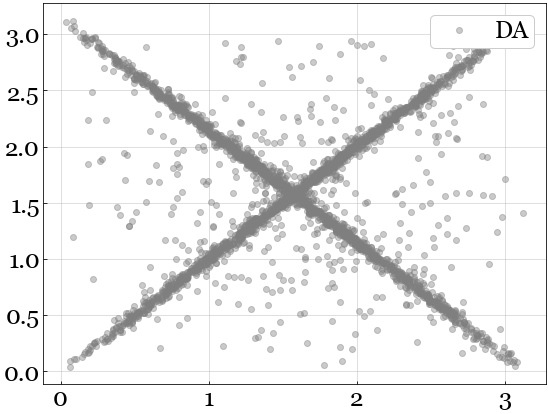

In [6]:
idx_da=t_m_da>5e3
idx_sa=t_m_sa>5e3

fig=plt.figure()

ax=fig.add_subplot(111)
ax.plot(I_S1_0_da, th_S1L_da,\
       ls='', marker='.', alpha=0.41, color='tab:grey', label=r'DA')
# ax.set_xlabel(r'Merger Time [yr]')
# ax.set_ylabel(r'$|\cos\theta_{S_1L}|/\left[|\cos\theta_{S_{1}L_{\rm o}}^{(0)}| +0.01\right]$')
ax.legend(loc='upper right', framealpha=1)



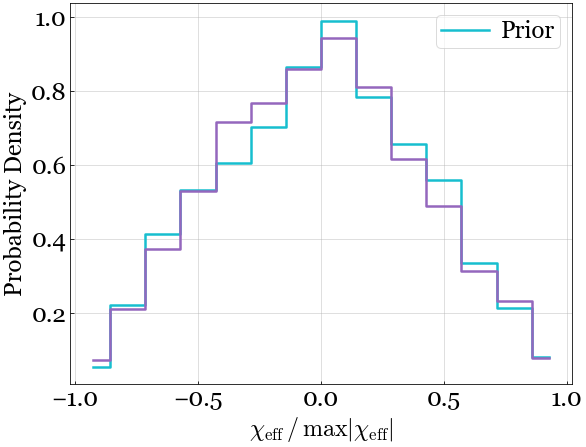

In [7]:
theta_S1L_0, theta_S2L_0 = data_init_da[:, 10], data_init_da[:, 11]

idx_da=t_m_da>5e3
idx_sa=t_m_sa>5e3
nbins=14

chi_eff_init_da_ref = (M1*np.cos(I_S1_0_da) + M2*np.cos(I_S2_0_da))/Mt

h_chie0_da, edges   = np.histogram(chi_eff_init_da[idx_da]/0.7, bins=nbins, range=(-1., 1.), density=True)
h_chie0_da_ref, edges   = np.histogram(chi_eff_init_da_ref[idx_da], bins=nbins, range=(-1., 1.), density=True)

mid = (edges[:-1] + edges[1:])/2.
fig=plt.figure()
ax=fig.add_subplot(111)
ax.step(mid, h_chie0_da, where='mid', label=r'Prior', color='tab:cyan')
ax.step(mid, h_chie0_da_ref, where='mid', color='tab:purple')
ax.set_xlabel(r'$\chi_{\rm eff}\,/\,\max |\chi_{\rm eff}|$')
ax.set_ylabel(r'Probability Density')
ax.legend()

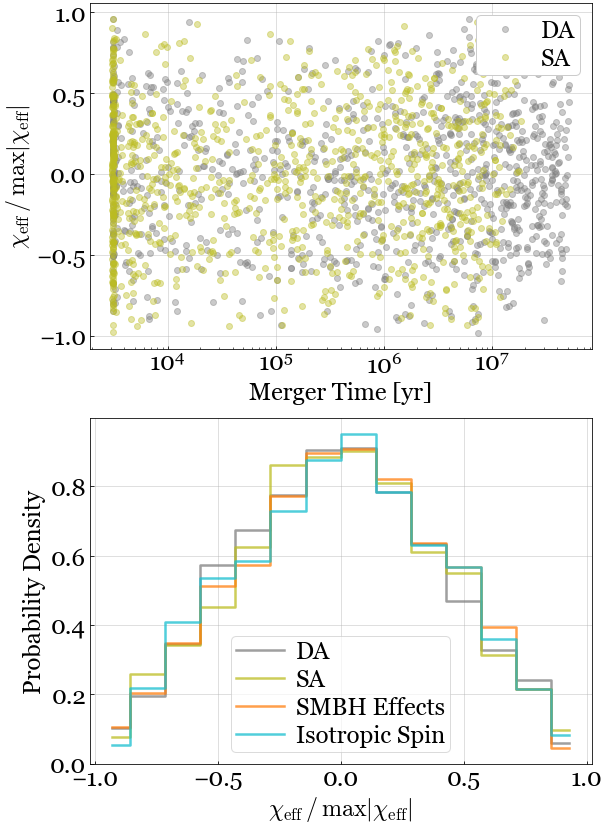

In [44]:
fig=plt.figure(figsize=(9, 14))
ax=fig.add_subplot(211)
ax.semilogx(t_m_da[:1000], chi_eff_da[:1000]/0.7, ls='', marker='.', alpha=0.41, label=r'DA', color='tab:grey')
# ax.semilogx(t_m_da, chi_eff_init_da, ls='', marker='.', alpha=0.5)
ax.semilogx(t_m_sa[:1000], chi_eff_init_sa[:1000]/0.7, ls='', marker='.', alpha=0.41, label=r'SA', color='tab:olive')
# ax.semilogx(t_m_smbh_45, chi_eff_init_smbh_45/0.7, ls='', marker='.', alpha=0.41, label=r'SMBH Effects', color='tab:cyan')
ax.set_xlabel(r'Merger Time [yr]')
ax.set_ylabel(r'$\chi_{\rm eff}\,/\,\max |\chi_{\rm eff}|$')
ax.legend(loc='upper right', framealpha=1)
# ax.axvline(7.5e3)


idx_da=t_m_da>-5e3
idx_sa=t_m_sa>-5e3
idx_smbh_45 = t_m_smbh_45 > -5e3
nbins=14

h_chie_da, edges = np.histogram(chi_eff_da[idx_da]/0.7, bins=nbins, range=(-1., 1.), density=True)
h_chie_sa, edges = np.histogram(chi_eff_sa[idx_sa]/0.7, bins=nbins, range=(-1., 1.), density=True)
h_chie0_da, __   = np.histogram(chi_eff_init_da[idx_da]/0.7, bins=nbins, range=(-1., 1.), density=True)

h_chie_smbh_45, __ = np.histogram(chi_eff_init_smbh_45[idx_smbh_45]/0.7, bins=nbins, range=(-1., 1.), density=True)

mid = (edges[:-1] + edges[1:])/2.

ax=fig.add_subplot(212)
ax.step(mid, h_chie_da, where='mid', alpha=0.75, label=r'DA', color='tab:grey')
ax.step(mid, h_chie_sa, where='mid', alpha=0.75, label=r'SA', color='tab:olive')
ax.step(mid, h_chie_smbh_45, where='mid', alpha=0.75, label=r'SMBH Effects', color='tab:orange')
ax.step(mid, h_chie0_da, where='mid', alpha=0.75, label=r'Isotropic Spin', color='tab:cyan')
ax.set_xlabel(r'$\chi_{\rm eff}\,/\,\max |\chi_{\rm eff}|$')
ax.set_ylabel(r'Probability Density')
ax.legend()
plt.savefig(fig_dir + 'chi_eff_dist.pdf')


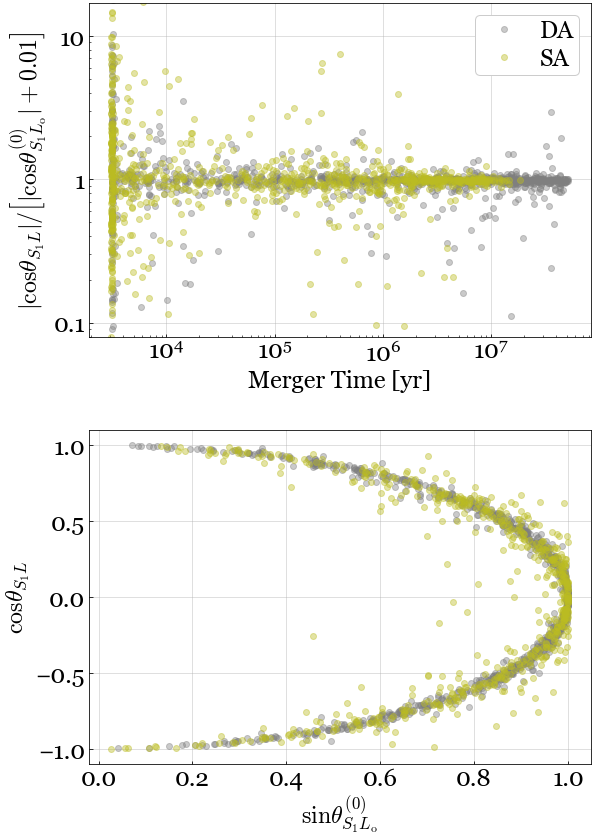

In [9]:
idx_da=t_m_da>5e3
idx_sa=t_m_sa>5e3

fig=plt.figure(figsize = (9, 14))

ax=fig.add_subplot(211)
ax.loglog(t_m_da[:1000], (np.abs(np.cos(th_S1L_da[:1000]))/(np.abs(np.cos(I_S1_0_da[:1000]))+1e-2)), \
       ls='', marker='.', alpha=0.41, color='tab:grey', label=r'DA')
ax.loglog(t_m_sa[:1000], (np.abs(np.cos(th_S1L_sa[:1000]))/(np.abs(np.cos(I_S1_0_sa[:1000]))+1e-2)), \
       ls='', marker='.', alpha=0.41, color='tab:olive', label=r'SA')
ax.set_ylim([0.08, 17])
ax.set_xlabel(r'Merger Time [yr]')
ax.set_ylabel(r'$|\cos\theta_{S_1L}|/\left[|\cos\theta_{S_{1}L_{\rm o}}^{(0)}| +0.01\right]$')
ax.legend(loc='upper right', framealpha=1)
ax.set_yticks([0.1, 1, 10])
ax.set_yticklabels([0.1, 1, 10])

ax=fig.add_subplot(212)
ax.plot(np.sin(I_S1_0_da[idx_da][:1000]), np.cos(th_S1L_da[idx_da][:1000]), \
        ls='', marker='.', alpha=0.41, color='tab:grey', label=r'DA')
# ax.plot(np.sin(I_S2_0_da[idx_da][:800]), np.cos(th_S2L_da[idx_da][:800]), \
#         ls='', marker='.', alpha=0.3, color='tab:grey')
ax.plot(np.sin(I_S1_0_sa[idx_sa]), np.cos(th_S1L_sa[idx_sa]), \
        ls='', marker='.', alpha=0.41, color='tab:olive', label=r'SA')
# ax.plot(np.sin(I_S2_0_sa[idx_sa]), np.cos(th_S2L_sa[idx_sa]), \
#         ls='', marker='.', alpha=0.3, color='tab:olive')


ax.set_xlabel(r'$\sin\left.\theta_{S_{1}L_{\rm o}}^{(0)}\right.$')
ax.set_ylabel(r'$\cos\left.\theta_{S_{1}L}\right.$')

fig.subplots_adjust(hspace = 0.28)

plt.savefig(fig_dir + 'cThSL_vs_sThS0.pdf')

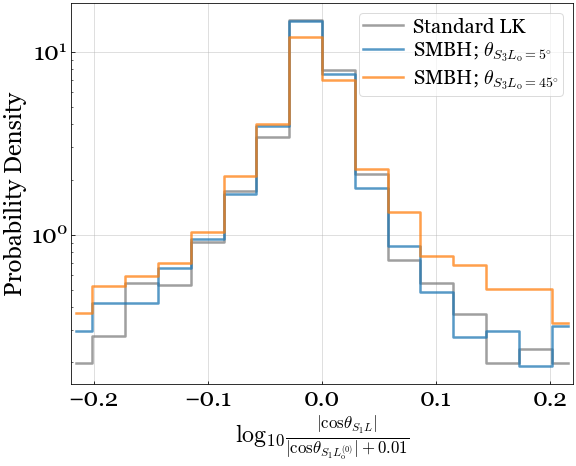

In [61]:
fig=plt.figure(figsize = (9, 7))

ax=fig.add_subplot(111)
idx_da=t_m_da>-5e3
idx_smbh_05=t_m_smbh_05>-5e3
idx_smbh_45=t_m_smbh_45>-5e3
nbins=16
h_ccr_da, edges_da = np.histogram(\
                    np.log10(np.abs(np.cos(th_S1L_da[idx_da]))/(np.abs(np.cos(I_S1_0_da[idx_da]))+1e-2)), \
                    bins=nbins, range=(-0.23, 0.23), density=True)
h_ccr_05, edges_05 = np.histogram(\
                    np.log10(np.abs(np.cos(th_S1L_smbh_05[idx_smbh_05]))/(np.abs(np.cos(I_S1_0_smbh_05[idx_smbh_05]))+1e-2)), \
                    bins=nbins, range=(-0.23, 0.23), density=True)
h_ccr_45, edges_45 = np.histogram(\
                    np.log10(np.abs(np.cos(th_S1L_smbh_45[idx_smbh_45]))/(np.abs(np.cos(I_S1_0_smbh_45[idx_smbh_45]))+1e-2)), \
                    bins=nbins, range=(-0.23, 0.23), density=True)
                                  
mid_da = (edges_da[:-1] + edges_da[1:])/2.
mid_05 = (edges_05[:-1] + edges_05[1:])/2.
mid_45 = (edges_45[:-1] + edges_45[1:])/2.


ax.step(mid_da, h_ccr_da, where='mid', alpha=0.75, label=r'Standard LK', color='tab:grey')
ax.step(mid_05, h_ccr_05, where='mid', alpha=0.75, label=r'SMBH; $\theta_{S_3L_{\rm o}=5^{\circ}}$', color='tab:blue')
ax.step(mid_45, h_ccr_45, where='mid', alpha=0.75, label=r'SMBH; $\theta_{S_3L_{\rm o}=45^{\circ}}$', color='tab:orange')
ax.set_yscale('log')
# ax.set_xticks([np.log10(0.6), np.log10(1.), np.log10(1.6)])
# ax.set_xticklabels([0.6, 1., 1.2])
ax.legend(fontsize=20)
ax.set_xlim([-0.22, 0.22])
ax.set_xlabel(r'$\log_{10} \frac{|\cos\theta_{S_1L}|}{|\cos\theta_{S_1L_{\rm o}^{(0)}}|+0.01}$')
ax.set_ylabel(r'Probability Density')
plt.savefig(fig_dir + 'cThSL_vs_cThS0_SMBH.pdf')

# ax=fig.add_subplot(212)
# idx_da=t_m_da>-5e3
# idx_smbh_05=t_m_smbh_05>-5e3
# idx_smbh_45=t_m_smbh_45>-5e3
# nbins=14

# h_chie_da, edges = np.histogram(chi_eff_da[idx_da]/0.7, bins=nbins, range=(-1., 1.), density=True)
# h_chie_smbh_05, __ = np.histogram(chi_eff_smbh_05[idx_smbh_05]/0.7, bins=nbins, range=(-1., 1.), density=True)
# h_chie_smbh_45, __ = np.histogram(chi_eff_smbh_45[idx_smbh_45]/0.7, bins=nbins, range=(-1., 1.), density=True)
# h_chie0_da, __   = np.histogram(chi_eff_init_da[idx_da]/0.7, bins=nbins, range=(-1., 1.), density=True)

# mid = (edges[:-1] + edges[1:])/2.
# # ax.step(mid, h_chie_da, where='mid', alpha=0.75, label=r'DA', color='tab:grey')
# ax.step(mid, h_chie_smbh_05, where='mid', alpha=0.75, label=r'SMBH', color='tab:blue')
# ax.step(mid, h_chie_smbh_45, where='mid', alpha=0.75, label=r'SMBH', color='tab:orange')
# ax.step(mid, h_chie0_da, where='mid', alpha=0.75, label=r'Prior', color='tab:cyan')
# ax.set_xlabel(r'$\chi_{\rm eff}\,/\,\max |\chi_{\rm eff}|$')


In [60]:
len(t_m_smbh_45)

1918

[Text(0, 0, '0.1'), Text(0, 0, '1'), Text(0, 0, '10')]

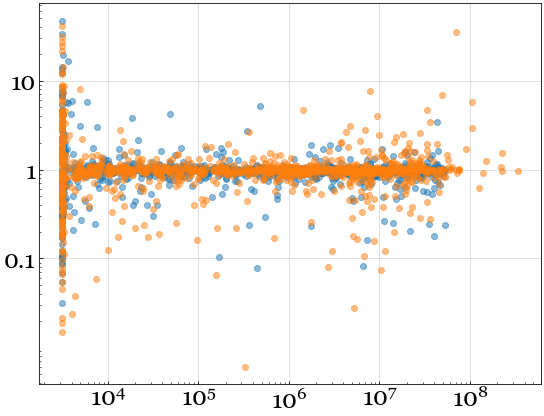

In [12]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.loglog(t_m_smbh_05, (np.abs(np.cos(th_S1L_smbh_05))/(np.abs(np.cos(I_S1_0_smbh_05))+1e-2)), \
           ls='', marker='.', alpha=0.5)
ax.semilogx(t_m_smbh_45, (np.abs(np.cos(th_S1L_smbh_45))/(np.abs(np.cos(I_S1_0_smbh_45))+1e-2)), \
           ls='', marker='.', alpha=0.5)

ax.set_yticks([0.1, 1, 10])
ax.set_yticklabels([0.1, 1, 10])

In [10]:
idx_da = (np.abs(chi_eff_da)<0.1) #& (t_m_da>10.e3)
idx_sa = (np.abs(chi_eff_sa)<0.1) #& (t_m_sa>10.e3)
print(len(chi_eff_da[idx_da]), len(chi_eff_sa[idx_sa]))

parConst = np.array([M1, M2, S1, S2])
# fig=plt.figure()
# ax=fig.add_subplot(111)
var_LK_da, pdf_LK_da \
    = pred_pdf_w_S(J_LK_da[idx_da], L_LK_da[idx_da], e_LK_da[idx_da], chi_eff_da[idx_da],\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=ax, cut=0)

var_300_da, pdf_300_da \
    = pred_pdf_w_S(J_300_da[idx_da], L_300_da[idx_da], e_300_da[idx_da], chi_eff_da[idx_da],\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=None, cut=0)

778 228


Text(0.5, 0, '$\\theta_{S_1S_2}$ [$^\\circ$]')

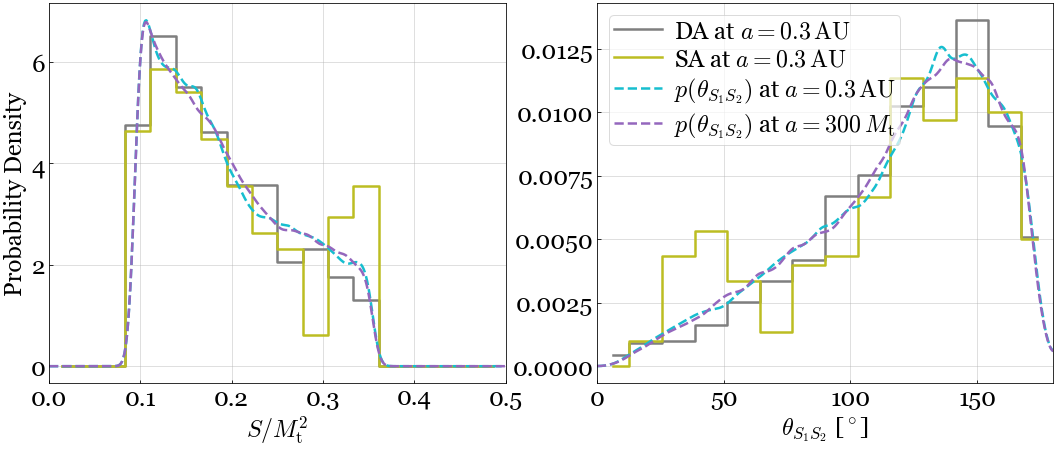

In [44]:
nbins=18
nbins_thSS=14
h_S_da, edges_S = np.histogram(S_LK_da[idx_da]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_S_sa, __ = np.histogram(S_LK_sa[idx_sa]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_thSS_da, edges_thSS = np.histogram(th_SS_da[idx_da]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)
h_thSS_sa, __ = np.histogram(th_SS_sa[idx_sa]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)

mid_S = (edges_S[1:] + edges_S[:-1])/2.
mid_thSS = (edges_thSS[1:] + edges_thSS[:-1])/2.
# mid = edges[:-1]

fig=plt.figure(figsize=(18, 7))
ax=fig.add_subplot(121)
ax.step(mid_S, h_S_da, where='mid', label=r'DA at $a = 10\,{\rm AU}$', color='tab:grey')
ax.step(mid_S, h_S_sa, where='mid', label=r'SA at $a = 10\,{\rm AU}$', color='tab:olive')
ax.plot(var_LK_da[0, :], g_filt(pdf_LK_da[0, :], 5), ls='--', label=r'$p(S)$ at $a = 0.3\,{\rm AU}$', color='tab:cyan')
ax.plot(var_300_da[0, :], g_filt(pdf_300_da[0, :], 5), ls='--', label=r'$p(S)$ at $a = 300\,M_{\rm t}$', color='tab:purple')
ax.set_xlim([0, 0.5])

# ax.plot(S_LK_v/S_Mt, 1./prob_S_LK_med_v/10., label=r'$\propto |{\rm d}S/{\rm d}t|/S\,|_{\overline{J}, \overline{L}}$')
# ax.legend()
ax.set_xlabel(r'$S/M_{\rm t}^2$')
ax.set_ylabel(r'Probability Density')

ax=fig.add_subplot(122)
ax.step(mid_thSS, h_thSS_da, where='mid', label=r'DA at $a = 0.3\,{\rm AU}$', color='tab:grey')
ax.step(mid_thSS, h_thSS_sa, where='mid', label=r'SA at $a = 0.3\,{\rm AU}$', color='tab:olive')
ax.plot(var_LK_da[-1, :], g_filt(pdf_LK_da[-1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 0.3\,{\rm AU}$', color='tab:cyan')
ax.plot(var_300_da[-1, :], g_filt(pdf_300_da[-1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 300\,M_{\rm t}$', color='tab:purple')
ax.set_xlim([0., 180.])
ax.legend()
ax.set_xlabel(r'$\theta_{S_1S_2}$ [$^\circ$]')
# ax.set_ylabel(r'Probability Density')

# plt.savefig(fig_dir + 'chi_eff_0_S_thSS_dist.pdf')

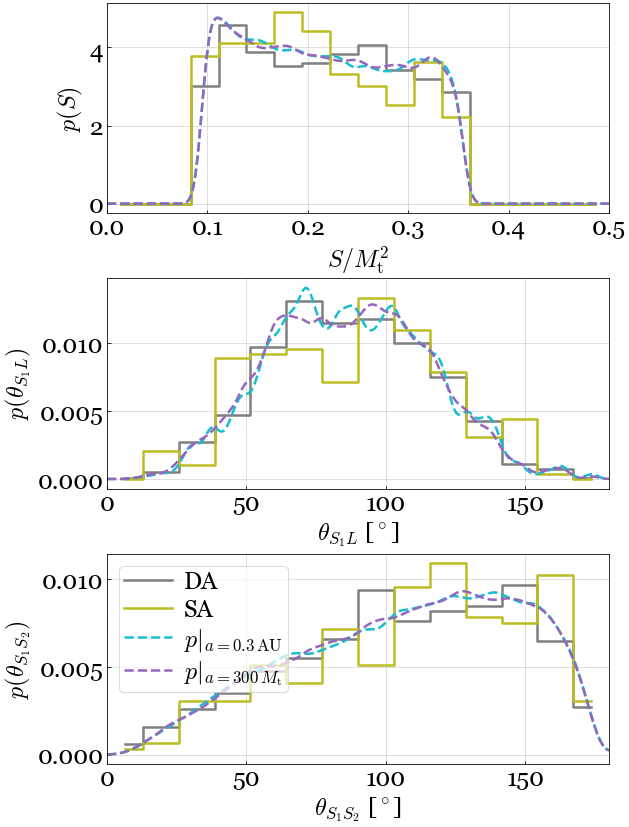

In [14]:
nbins=18
nbins_thSS=14
h_S_da, edges_S = np.histogram(S_LK_da[idx_da]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_S_sa, __ = np.histogram(S_LK_sa[idx_sa]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_thSS_da, edges_thSS = np.histogram(th_SS_da[idx_da]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)
h_thSS_sa, __ = np.histogram(th_SS_sa[idx_sa]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)
h_thS1L_da, __ = np.histogram(th_S1L_da[idx_da]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)
h_thS1L_sa, __ = np.histogram(th_S1L_sa[idx_sa]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)
h_thS2L_da, __ = np.histogram(th_S2L_da[idx_da]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)
h_thS2L_sa, __ = np.histogram(th_S2L_sa[idx_sa]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)

mid_S = (edges_S[1:] + edges_S[:-1])/2.
mid_thSS = (edges_thSS[1:] + edges_thSS[:-1])/2.
# mid = edges[:-1]

fig=plt.figure(figsize=(9, 14))
ax=fig.add_subplot(311)
ax.step(mid_S, h_S_da, where='mid', label=r'DA', color='tab:grey')
ax.step(mid_S, h_S_sa, where='mid', label=r'SA', color='tab:olive')
ax.plot(var_LK_da[0, :], g_filt(pdf_LK_da[0, :], 5), ls='--', label=r'$p|_{a = 0.3\,{\rm AU}}$', color='tab:cyan')
ax.plot(var_300_da[0, :], g_filt(pdf_300_da[0, :], 5), ls='--', label=r'$p|_{a = 300\,M_{\rm t}}$', color='tab:purple')
ax.set_xlim([0, 0.5])

# ax.plot(S_LK_v/S_Mt, 1./prob_S_LK_med_v/10., label=r'$\propto |{\rm d}S/{\rm d}t|/S\,|_{\overline{J}, \overline{L}}$')
# ax.legend()
ax.set_xlabel(r'$S/M_{\rm t}^2$')
ax.set_ylabel(r'$p(S)$')


ax=fig.add_subplot(312)
ax.step(mid_thSS, h_thS1L_da, where='mid', label=r'DA at $a = 0.3\,{\rm AU}$', color='tab:grey')
ax.step(mid_thSS, h_thS1L_sa, where='mid', label=r'SA at $a = 0.3\,{\rm AU}$', color='tab:olive')
ax.plot(var_LK_da[1, :], g_filt(pdf_LK_da[1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 0.3\,{\rm AU}$', color='tab:cyan')
ax.plot(var_300_da[1, :], g_filt(pdf_300_da[1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 300\,M_{\rm t}$', color='tab:purple')
ax.set_xlim([0., 180.])
# ax.legend()
ax.set_xlabel(r'$\theta_{S_1L}$ [$^\circ$]')
ax.set_ylabel(r'$p(\theta_{S_1L})$')

ax=fig.add_subplot(313)
ax.step(mid_thSS, h_thSS_da, where='mid', label=r'DA', color='tab:grey')
ax.step(mid_thSS, h_thSS_sa, where='mid', label=r'SA', color='tab:olive')
ax.plot(var_LK_da[-1, :], g_filt(pdf_LK_da[-1, :], 5), ls='--', label=r'$p|_{a = 0.3\,{\rm AU}}$', color='tab:cyan')
ax.plot(var_300_da[-1, :], g_filt(pdf_300_da[-1, :], 5), ls='--', label=r'$p|_{a = 300\,M_{\rm t}}$', color='tab:purple')
ax.set_xlim([0., 180.])
ax.legend(loc='upper left')
ax.set_xlabel(r'$\theta_{S_1S_2}$ [$^\circ$]')
ax.set_ylabel(r'$p(\theta_{S_1S_2})$')
plt.subplots_adjust(hspace=0.31)
plt.savefig(fig_dir + 'chi_eff_0_S_thSS_dist.pdf')

In [35]:
idx_da = (chi_eff_da<0.4) & (chi_eff_da>0.3) #& (t_m_da>2.e7)
print(len(chi_eff_da[idx_da]))

parConst = np.array([M1, M2, S1, S2])
# fig=plt.figure()
# ax=fig.add_subplot(111)
var_LK_da, pdf_LK_da \
    = pred_pdf_w_S(J_LK_da[idx_da], L_LK_da[idx_da], e_LK_da[idx_da], chi_eff_da[idx_da],\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=ax, cut=0)

var_600_da, pdf_600_da \
    = pred_pdf_w_S(J_600_da[idx_da], L_600_da[idx_da], e_600_da[idx_da], chi_eff_da[idx_da],\
                 parConst,\
                 nPtPDF=400, nPt=100, ax=None, cut=0)

549


Text(0.5, 0, '$\\theta_{S_1S_2}$ [$^\\circ$]')

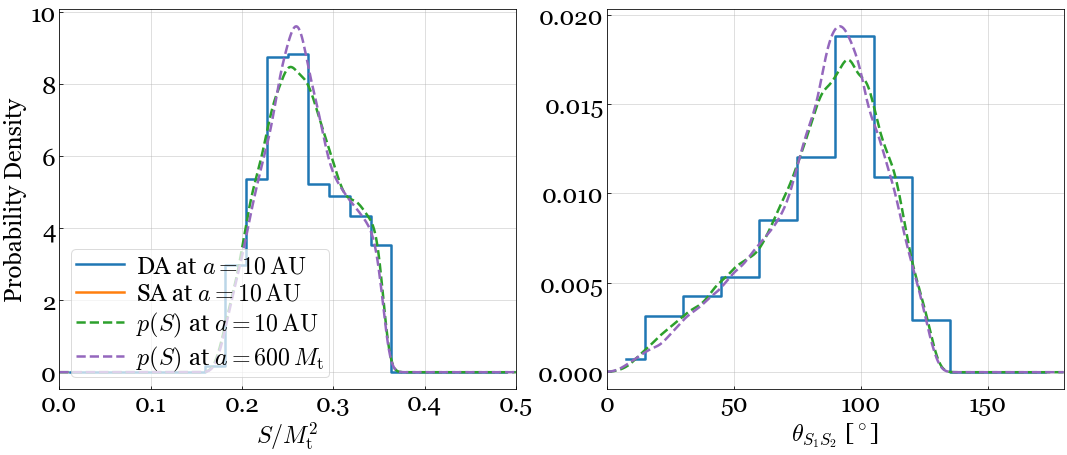

In [39]:
nbins=22
nbins_thSS=12
h_S_da, edges_S = np.histogram(S_LK_da[idx_da]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_S_sa, __ = np.histogram(S_LK_sa[idx_sa]/S_Mt, bins=nbins, range=(0., 0.5), density=True)
h_thSS_da, edges_thSS = np.histogram(th_SS_da[idx_da]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)
h_thSS_sa, __ = np.histogram(th_SS_sa[idx_sa]*180./np.pi, bins=nbins_thSS, range=(0., 180.), density=True)

mid_S = (edges_S[1:] + edges_S[:-1])/2.
mid_thSS = (edges_thSS[1:] + edges_thSS[:-1])/2.
# mid = edges[:-1]

fig=plt.figure(figsize=(18, 7))
ax=fig.add_subplot(121)
ax.step(mid_S, h_S_da, where='mid', label=r'DA at $a = 10\,{\rm AU}$')
ax.step(mid_S, h_S_sa, where='mid', label=r'SA at $a = 10\,{\rm AU}$')
ax.plot(var_LK_da[0, :], g_filt(pdf_LK_da[0, :], 5), ls='--', label=r'$p(S)$ at $a = 10\,{\rm AU}$')
ax.plot(var_600_da[0, :], g_filt(pdf_600_da[0, :], 5), color='tab:purple', ls='--', label=r'$p(S)$ at $a = 600\,M_{\rm t}$')
ax.set_xlim([0, 0.5])

# ax.plot(S_LK_v/S_Mt, 1./prob_S_LK_med_v/10., label=r'$\propto |{\rm d}S/{\rm d}t|/S\,|_{\overline{J}, \overline{L}}$')
ax.legend(loc='lower left')
ax.set_xlabel(r'$S/M_{\rm t}^2$')
ax.set_ylabel(r'Probability Density')

ax=fig.add_subplot(122)
ax.step(mid_thSS, h_thSS_da, where='mid', label=r'DA at $a = 10\,{\rm AU}$')
ax.step(mid_thSS, h_thSS_sa, where='mid', label=r'SA at $a = 10\,{\rm AU}$')
ax.plot(var_LK_da[-1, :], g_filt(pdf_LK_da[-1, :], 5), ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 10\,{\rm AU}$')
ax.plot(var_600_da[-1, :], g_filt(pdf_600_da[-1, :], 5), color='tab:purple', ls='--', label=r'$p(\theta_{S_1S_2})$ at $a = 600\,M_{\rm t}$')
ax.set_xlim([0., 180.])
# ax.legend()
ax.set_xlabel(r'$\theta_{S_1S_2}$ [$^\circ$]')
# ax.set_ylabel(r'Probability Density')

# plt.savefig(fig_dir + 'chi_eff_0_S_thSS_dist.pdf')

## Distribution at the merger from binary evolution

In [20]:
data_dir = 'run_LK2merger/data/fix_init_spin_ang/bin2merg/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/chi_eff_0/'
fig_dir_f = '/home/hang.yu/public_html/astro/LK_evol/LK2merger/fix_init_spin_ang/bin2merg/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/chi_eff_0/'

# data_dir = 'run_LK2merger/data/fix_init_spin_ang/bin2merg/'

if not os.path.exists(fig_dir_f):
    os.makedirs(fig_dir_f)

data=np.zeros([0, 14])
nFile=10
for i in range(100, 100+nFile, 1):
# for i in range(nFile):
    if os.path.exists(data_dir + 'id_%i_bin_evol.txt'%i):
        data_ = np.loadtxt(data_dir + 'id_%i_bin_evol.txt'%i) 
        data = np.vstack([data, data_])
        
M1, M2 = data[0, 0]*Ms, data[0, 1]*Ms
qq = M2/M1
Mt = (M1+M2) 
mu = M1 * M2/ Mt

r_Mt = G*Mt/c**2.
S_Mt = G*Mt**2./c
r_isco = 6.*r_Mt

chi1, chi2 = data[0, 2], data[0, 3]
S1, S2=chi1 * G*M1**2./c, chi2 * G*M2**2./c
print(chi1, chi2)
chi_eff_v_f=data[:, 4]

J_init_f, L_init_f, S_init_f = data[:, 5]*S_Mt, data[:, 6]*S_Mt, data[:, 7]*S_Mt
r_init = 300.*r_Mt
eff_init_f = L_init_f/(mu*np.sqrt(G*Mt*r_init))
e_init_f = np.sqrt(1.-eff_init_f**2.)

J_v_f, L_v_f, S_v_f = data[:, 8]*S_Mt, data[:, 9]*S_Mt, data[:, 10]*S_Mt
th_S1L_f, th_S2L_f, th_SS_f = data[:, 11], data[:, 12], data[:, 13]

dphi_f = (np.cos(th_SS_f) - np.cos(th_S1L_f)*np.cos(th_S2L_f)) / np.sin(th_S1L_f) / np.sin(th_S2L_f)
dphi_f = np.arccos(dphi_f)

print(np.median(J_v_f)/S_Mt, np.median(L_v_f)/S_Mt, np.median(S_v_f)/S_Mt)
print(np.median((J_v_f**2.-L_v_f**2.)/(2.*L_v_f**2.)))
print(np.median((S_v_f**2.-S1**2.-S2**2.)/(2.*S1*S2)))

nSamp_f = len(J_v_f)
th_S1L_init_f, th_S2L_init_f, th_SS_init_f = np.zeros(nSamp_f), np.zeros(nSamp_f), np.zeros(nSamp_f)
dphi_init_f = np.zeros(nSamp_f)


omega_dS = 1.5 * G*(M2+mu/3.)/(c**2.*r_isco) * np.sqrt(G*Mt/r_isco**3.)
omega_dS_br = 0.5 * G*S2*(4.+3.*M1/M2)/(c**2. * r_isco**3.)
print(omega_dS, omega_dS_br, omega_dS_br/omega_dS)

for i in range(nSamp_f):
    par = np.array([M1, M2, S1, S2, chi_eff_v_f[i]])
    th_S1L_init_f[i], th_S2L_init_f[i], th_SS_init_f[i],  dphi_init_f[i]\
        = get_angles(J_init_f[i], L_init_f[i], e_init_f[i], S_init_f[i], par)
    
chi1_p_init_f = chi1*np.sin(th_S1L_init_f)
chi2_p_init_f = chi2*np.sin(th_S2L_init_f)

0.7 0.7
0.640646 0.601486 0.171798
0.06722478023995937
-0.6479457546073073
11.860913133900631 3.2628265466299817 0.27509067049013575


In [5]:
# chi1x, chi1y, chi1z = np.zeros(nSamp_f), np.zeros(nSamp_f), np.zeros(nSamp_f)
# chi2x, chi2y, chi2z = np.zeros(nSamp_f), np.zeros(nSamp_f), np.zeros(nSamp_f)
# chi3x, chi3y, chi3z = np.zeros(nSamp_f), np.zeros(nSamp_f), np.zeros(nSamp_f)

# for i in range(nSamp_f):
#     par = np.array([M1, M2, S1, S2, chi_eff_v_f[i]])
#     th_S1L, th_S2L, th_SS,  dphi\
#         = get_angles(J_v_f[i], L_v_f[i], 0, S_v_f[i], par)
#     chi1x[i] = np.sin(th_S1L) * chi1
#     chi1z[i] = np.cos(th_S1L) * chi1
    
#     chi2x[i] = np.sin(th_S2L) * np.cos(dphi) * chi2
#     chi2y[i] = np.sin(th_S2L) * np.sin(dphi) * chi2
#     chi2z[i] = np.cos(th_S2L) * chi2
    
#     # a reference sample
#     chi3z[i] = ((M1+M2)*chi_eff_v_f[i] - M1*chi1z[i])/M2
#     chi3p = np.sqrt(chi2**2. - chi3z[i]**2.)
#     phi = np.random.uniform(low=0., high=2.*np.pi)
#     chi3x[i] = chi3p * np.cos(phi)
#     chi3y[i] = chi3p * np.sin(phi)

    
# chi1p = np.sqrt(chi1x**2. + chi1y**2.)

# idx = chi1p > 0.68
# print(len(chi1x[idx]))
# chi1x, chi1y, chi1z = chi1x[idx], chi1y[idx], chi1z[idx]
# chi2x, chi2y, chi2z = chi2x[idx], chi2y[idx], chi2z[idx]
# chi3x, chi3y, chi3z = chi3x[idx], chi3y[idx], chi3z[idx]

# fid_dir=fig_dir_f + 'spin_data/'
# if not os.path.exists(fid_dir):
#     os.makedirs(fid_dir)
    
# fid=h5.File(fid_dir+'spin_data_ISCO.h5', 'w')
# fid.attrs['M1'] = M1/Ms
# fid.attrs['M2'] = M2/Ms
# fid.attrs['chi1'], fid.attrs['chi2'] = chi1, chi2

# fid.create_dataset('chi1x', dtype=np.float, shape=chi1x.shape, data=chi1x)
# fid.create_dataset('chi1y', dtype=np.float, shape=chi1y.shape, data=chi1y)
# fid.create_dataset('chi1z', dtype=np.float, shape=chi1z.shape, data=chi1z)
# fid.create_dataset('chi2x', dtype=np.float, shape=chi2x.shape, data=chi2x)
# fid.create_dataset('chi2y', dtype=np.float, shape=chi2y.shape, data=chi2y)
# fid.create_dataset('chi2z', dtype=np.float, shape=chi2z.shape, data=chi2z)

# fid.close()

# fid=h5.File(fid_dir+'spin_data_ISCO_uniform_phi12.h5', 'w')
# fid.attrs['M1'] = M1/Ms
# fid.attrs['M2'] = M2/Ms
# fid.attrs['chi1'], fid.attrs['chi2'] = chi1, chi2

# fid.create_dataset('chi1x', dtype=np.float, shape=chi1x.shape, data=chi1x)
# fid.create_dataset('chi1y', dtype=np.float, shape=chi1y.shape, data=chi1y)
# fid.create_dataset('chi1z', dtype=np.float, shape=chi1z.shape, data=chi1z)
# fid.create_dataset('chi2x', dtype=np.float, shape=chi2x.shape, data=chi3x)
# fid.create_dataset('chi2y', dtype=np.float, shape=chi2y.shape, data=chi3y)
# fid.create_dataset('chi2z', dtype=np.float, shape=chi2z.shape, data=chi3z)

# fid.close()

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in arccos
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in sqrt


889


In [24]:
data_dir = 'run_LK2merger/data/rand_init_spin_ang/bin2merg/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/chi_eff_0/'
fig_dir_r = '/home/hang.yu/public_html/astro/LK_evol/LK2merger/rand_init_spin_ang/bin2merg/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/chi_eff_0/'

if not os.path.exists(fig_dir_r):
    os.makedirs(fig_dir_r)

data=np.zeros([0, 14])
pre_cond = np.zeros([0, 2])
nFile=10
for i in range(100, 100+nFile, 1):
    if os.path.exists(data_dir + 'id_%i_bin_evol.txt'%i):
        data_ = np.loadtxt(data_dir + 'id_%i_bin_evol.txt'%i) 
        data = np.vstack([data, data_])
        
        pre_cond_ = np.loadtxt(data_dir + 'id_%i_bin_pre_cond.txt'%i)
        pre_cond = np.vstack([pre_cond, pre_cond_])
        
M1, M2 = data[0, 0]*Ms, data[0, 1]*Ms
qq = M2/M1
Mt = (M1+M2) 
mu = M1 * M2/ Mt

r_Mt = G*Mt/c**2.
S_Mt = G*Mt**2./c
r_isco = 6.*r_Mt

u_m_e_r, t_m_r = pre_cond[:, 0], pre_cond[:, 1]

chi1, chi2 = data[0, 2], data[0, 3]
S1, S2=chi1 * G*M1**2./c, chi2 * G*M2**2./c
print(chi1, chi2)
chi_eff_v_r=data[:, 4]

J_init_r, L_init_r, S_init_r = data[:, 5]*S_Mt, data[:, 6]*S_Mt, data[:, 7]*S_Mt
r_init = 300.*r_Mt
eff_init_r = L_init_r/(mu*np.sqrt(G*Mt*r_init))
e_init_r = np.sqrt(1.-eff_init_r**2.)

J_v_r, L_v_r, S_v_r = data[:, 8]*S_Mt, data[:, 9]*S_Mt, data[:, 10]*S_Mt
th_S1L_r, th_S2L_r, th_SS_r = data[:, 11], data[:, 12], data[:, 13]

dphi_r = (np.cos(th_SS_r) - np.cos(th_S1L_r)*np.cos(th_S2L_r)) / np.sin(th_S1L_r) / np.sin(th_S2L_r)
dphi_r = np.arccos(dphi_r)

print(np.median(J_v_r)/S_Mt, np.median(L_v_r)/S_Mt, np.median(S_v_r)/S_Mt)
print(np.median((J_v_r**2.-L_v_r**2.)/(2.*L_v_r**2.)))
print(np.median((S_v_r**2.-S1**2.-S2**2.)/(2.*S1*S2)))

nSamp_r = len(J_v_r)
th_S1L_init_r, th_S2L_init_r, th_SS_init_r = np.zeros(nSamp_r), np.zeros(nSamp_r), np.zeros(nSamp_r)
dphi_init_r = np.zeros(nSamp_r)


omega_dS = 1.5 * G*(M2+mu/3.)/(c**2.*r_isco) * np.sqrt(G*Mt/r_isco**3.)
omega_LT = 0.5 * G*S2/(c**2. * r_isco**3.)
print(omega_dS, omega_LT, omega_LT/omega_dS)

for i in range(nSamp_r):
    par = np.array([M1, M2, S1, S2, chi_eff_v_r[i]])
    th_S1L_init_r[i], th_S2L_init_r[i], th_SS_init_r[i],  dphi_init_r[i]\
        = get_angles(J_init_r[i], L_init_r[i], e_init_r[i], S_init_r[i], par)
    

chi1_p_init_r = chi1*np.sin(th_S1L_init_r)
chi2_p_init_r = chi2*np.sin(th_S2L_init_r)

0.7 0.7
0.6491250000000001 0.601486 0.2262005
0.08233866829383475
-0.28152953002798736
11.860913133900631 0.4118130592833957 0.034720181712347226


/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in arccos


In [16]:
# chi1x, chi1y, chi1z = np.zeros(nSamp_r), np.zeros(nSamp_r), np.zeros(nSamp_r)
# chi2x, chi2y, chi2z = np.zeros(nSamp_r), np.zeros(nSamp_r), np.zeros(nSamp_r)

# for i in range(nSamp_r):
#     par = np.array([M1, M2, S1, S2, chi_eff_v_r[i]])
#     th_S1L, th_S2L, th_SS,  dphi\
#         = get_angles(J_v_r[i], L_v_r[i], 0, S_v_r[i], par)
#     chi1x[i] = np.sin(th_S1L) * chi1
#     chi1z[i] = np.cos(th_S1L) * chi1
    
#     chi2x[i] = np.sin(th_S2L) * np.cos(dphi) * chi2
#     chi2y[i] = np.sin(th_S2L) * np.sin(dphi) * chi2
#     chi2z[i] = np.cos(th_S2L) * chi2
    
# fid=fig_dir_r + 'spin_data/'
# if not os.path.exists(fid):
#     os.makedirs(fid)
    
# fid=h5.File(fid+'spin_data_ISCO.h5', 'w')
# fid.attrs['M1'] = M1/Ms
# fid.attrs['M2'] = M2/Ms
# fid.attrs['chi1'], fid.attrs['chi2'] = chi1, chi2

# fid.create_dataset('chi1x', dtype=np.float, shape=chi1x.shape, data=chi1x)
# fid.create_dataset('chi1y', dtype=np.float, shape=chi1y.shape, data=chi1y)
# fid.create_dataset('chi1z', dtype=np.float, shape=chi1z.shape, data=chi1z)
# fid.create_dataset('chi2x', dtype=np.float, shape=chi2x.shape, data=chi2x)
# fid.create_dataset('chi2y', dtype=np.float, shape=chi2y.shape, data=chi2y)
# fid.create_dataset('chi2z', dtype=np.float, shape=chi2z.shape, data=chi2z)

# fid.close()

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in arccos


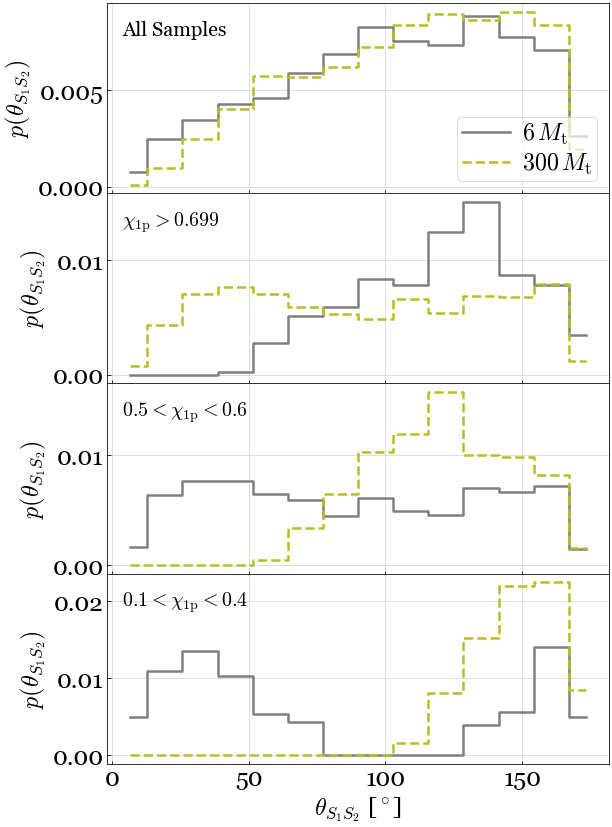

In [22]:
fig=plt.figure(figsize=(9, 14))

idx = (chi1_p_init_r > -1) & (chi1_p_init_r < 1)
h_SS, edges = np.histogram(th_SS_r[idx]*180./np.pi, bins=14, range=(0, 180.), density=True)
h_SS0, edges = np.histogram(th_SS_init_r[idx]*180./np.pi, bins=14, range=(0, 180.), density=True)
mid = (edges[1:] + edges[:-1])/2.
ax=fig.add_subplot(411)
ax.step(mid, h_SS, where='mid', color='tab:grey', label=r'$6\,M_{\rm t}$')
ax.step(mid, h_SS0, where='mid', color='tab:olive', ls='--', label=r'$300\,M_{\rm t}$')
ax.set_xticklabels([])
ax.legend(loc='lower right')
ax.text(0.03, 0.83, r'All Samples', transform=ax.transAxes)
ax.set_ylabel(r'$p(\theta_{S_1S_2})$')

idx = (chi1_p_init_r > 0.699) & (chi1_p_init_r < 0.9)
h_SS, edges = np.histogram(th_SS_r[idx]*180./np.pi, bins=14, range=(0, 180.), density=True)
h_SS0, edges = np.histogram(th_SS_init_r[idx]*180./np.pi, bins=14, range=(0, 180.), density=True)
mid = (edges[1:] + edges[:-1])/2.
ax=fig.add_subplot(412)
ax.step(mid, h_SS, where='mid', color='tab:grey')
ax.step(mid, h_SS0, where='mid', color='tab:olive', ls='--')
ax.set_xticklabels([])
ax.text(0.03, 0.83, r'$\chi_{\rm 1p}>0.699$', transform=ax.transAxes)
ax.set_ylabel(r'$p(\theta_{S_1S_2})$')

idx = (chi1_p_init_r > 0.5) & (chi1_p_init_r < 0.6)
h_SS, edges = np.histogram(th_SS_r[idx]*180./np.pi, bins=14, range=(0, 180.), density=True)
h_SS0, edges = np.histogram(th_SS_init_r[idx]*180./np.pi, bins=14, range=(0, 180.), density=True)
mid = (edges[1:] + edges[:-1])/2.
ax=fig.add_subplot(413)
ax.step(mid, h_SS, where='mid', color='tab:grey')
ax.step(mid, h_SS0, where='mid', color='tab:olive', ls='--')
ax.set_xticklabels([])
ax.text(0.03, 0.83, r'$0.5<\chi_{\rm 1p}<0.6$', transform=ax.transAxes)
ax.set_ylabel(r'$p(\theta_{S_1S_2})$')

idx = (chi1_p_init_r > 0.1) & (chi1_p_init_r < 0.4)
h_SS, edges = np.histogram(th_SS_r[idx]*180./np.pi, bins=14, range=(0, 180.), density=True)
h_SS0, edges = np.histogram(th_SS_init_r[idx]*180./np.pi, bins=14, range=(0, 180.), density=True)
mid = (edges[1:] + edges[:-1])/2.
ax=fig.add_subplot(414)
ax.step(mid, h_SS, where='mid', color='tab:grey')
ax.step(mid, h_SS0, where='mid', color='tab:olive', ls='--')
ax.text(0.03, 0.83, r'$0.1<\chi_{\rm 1p}<0.4$', transform=ax.transAxes)
ax.set_ylabel(r'$p(\theta_{S_1S_2})$')
ax.set_xlabel(r'$\theta_{S_1S_2}$ [$^\circ$]')

plt.subplots_adjust(hspace=0)
# print((J_v_f**2. +S_v_f**2.)/S_Mt**2.)

plt.savefig(fig_dir_r+'th12_6M_vs_300M.pdf')

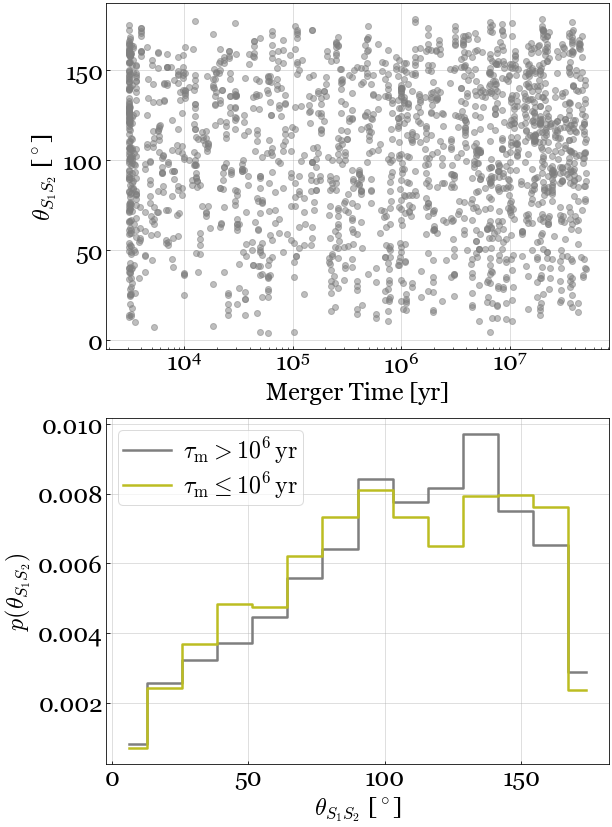

In [25]:
idx_g1e6 = t_m_r > 1.e6
idx_l1e6 = t_m_r <= 1.e6

h_g, edges = np.histogram(th_SS_r[idx_g1e6]*180./np.pi, bins=14, range=(0, 180.), density=True)
h_l, edges = np.histogram(th_SS_r[idx_l1e6]*180./np.pi, bins=14, range=(0, 180.), density=True)

mid = (edges[1:] + edges[:-1])/2.

fig=plt.figure(figsize=(9, 14))
ax=fig.add_subplot(211)
ax.semilogx(t_m_r[:2000], th_SS_r[:2000]*180./np.pi, ls='', marker='.', color='tab:grey', alpha=0.5)
ax.set_xlabel(r'Merger Time [yr]')
ax.set_ylabel(r'$\theta_{S_1S_2}$ [$^\circ$]')



ax=fig.add_subplot(212)
ax.step(mid, h_g, where='mid', color='tab:grey', label=r'$\tau_{\rm m} > 10^6\,{\rm yr}$')
ax.step(mid, h_l, where='mid', color='tab:olive', label=r'$\tau_{\rm m} \leq 10^6\,{\rm yr}$')
ax.set_xlabel(r'$\theta_{S_1S_2}$ [$^\circ$]')
ax.set_ylabel(r'$p(\theta_{S_1S_2})$')
ax.legend()

plt.savefig(fig_dir_r+'th_12_vs_tau_m.pdf')

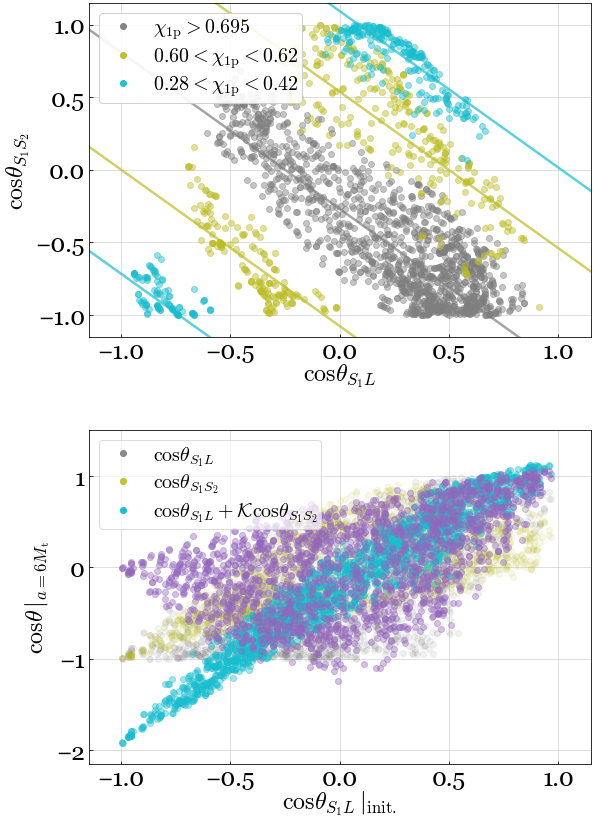

In [34]:
ang1 = np.pi/2.
ang2 = np.pi/3.
ang3 = np.pi/6.

lb1 = 0.993 * np.sin(ang1)*chi1
lb2 = 0.985 * np.sin(ang2)*chi1
ub2 = 1.015 * np.sin(ang2)*chi1
lb3 = 0.8 * np.sin(ang3)*chi1
ub3 = 1.2 * np.sin(ang3)*chi1

idx1 = chi1_p_init_r  > lb1
idx2 = (chi1_p_init_r > lb2) & (chi1_p_init_r < ub2)
idx3 = (chi1_p_init_r > lb3) & (chi1_p_init_r < ub3)

kap_r = S2/((1.-qq)*mu*np.sqrt(G*Mt*6.*r_Mt))
c_th_S1L_plot=np.arange(-2., 2., 0.5)
c_th_SS_plot1 = (-0.25+np.cos(ang1)-c_th_S1L_plot)/kap_r 
c_th_SS_plot21 = (+np.cos(ang2)-c_th_S1L_plot)/kap_r
c_th_SS_plot22 = (-0.5-np.cos(ang2)-c_th_S1L_plot)/kap_r
c_th_SS_plot31 = (0.15+np.cos(ang3)-c_th_S1L_plot)/kap_r
c_th_SS_plot32 = (-0.8-np.cos(ang3)-c_th_S1L_plot)/kap_r


fig=plt.figure(figsize=(9, 14))
ax=fig.add_subplot(211)
ax.plot(np.cos(th_S1L_r[idx1]), np.cos(th_SS_r[idx1]), ls='', marker='.', alpha=0.45, color='tab:grey')
ax.plot(np.cos(th_S1L_r[idx2]), np.cos(th_SS_r[idx2]), ls='', marker='.', alpha=0.45, color='tab:olive')
ax.plot(np.cos(th_S1L_r[idx3]), np.cos(th_SS_r[idx3]), ls='', marker='.', alpha=0.45, color='tab:cyan')

ax.plot([], [], ls='', marker='.', color='tab:grey', alpha=0.95, \
        label=r'$\chi_{\rm 1p} {>} %.3f$'%lb1)
ax.plot([], [], ls='', marker='.', color='tab:olive', alpha=0.95, \
       label=r'$%.2f{{<}}\chi_{\rm 1p} {{<}} %.2f$'%(lb2, ub2))
ax.plot([], [], ls='', marker='.', color='tab:cyan', alpha=0.95, \
        label=r'$%.2f{{<}}\chi_{\rm 1p} {{<}} %.2f$'%(lb3, ub3) )

ax.plot(c_th_S1L_plot, c_th_SS_plot1, color='tab:grey', alpha=0.7)
ax.plot(c_th_S1L_plot, c_th_SS_plot21, color='tab:olive', alpha=0.7)
ax.plot(c_th_S1L_plot, c_th_SS_plot22, color='tab:olive', alpha=0.7)
ax.plot(c_th_S1L_plot, c_th_SS_plot31, color='tab:cyan', alpha=0.7)
ax.plot(c_th_S1L_plot, c_th_SS_plot32, color='tab:cyan', alpha=0.7)

ax.set_xlim([-1.15, 1.15])
ax.set_ylim([-1.15, 1.15])
ax.legend(loc='upper left', framealpha=.9, fontsize='medium')

ax.set_xlabel(r'$\cos \theta_{S_1L}$', labelpad=-2)
ax.set_ylabel(r'$\cos \theta_{S_1S_2}$')


ax=fig.add_subplot(212)

full =  np.cos(th_S1L_r) * (1. + qq**2.*S_Mt*chi_eff_v_r/((1.+qq)**2.*(1.-qq)*L_v_r) )\
         - (qq*S1/2./L_v_r/(1.-qq))*np.cos(th_S1L_r)**2. + kap_r * np.cos(th_SS_r)
full_0 = np.cos(th_S1L_init_r) * (1. + qq**2.*S_Mt*chi_eff_v_r/((1.+qq)**2.*(1.-qq)*L_init_r) )\
         - (qq*S1/2./L_init_r/(1.-qq))*np.cos(th_S1L_init_r)**2. + S2/((1.-qq)*L_init_r) * np.cos(th_SS_init_r)

DD = (1. + qq**2.*S_Mt*chi_eff_v_r/((1.+qq)**2.*(1.-qq)*L_v_r) ) * (np.cos(th_S1L_r) - np.cos(th_S1L_init_r))\
    - (qq*S1/2./L_v_r/(1.-qq)) * (np.cos(th_S1L_r)**2. - np.cos(th_S1L_init_r)**2.) \
    + kap_r * (np.cos(th_SS_r) - np.cos(th_SS_init_r))
DD = (np.cos(th_S1L_r) - np.cos(th_S1L_init_r)) + kap_r * (np.cos(th_SS_r) - np.cos(th_SS_init_r))


ax.plot(np.cos(th_S1L_init_r[:2000]), np.cos(th_SS_r[:2000]), ls='', marker='.', color='tab:grey', alpha=0.1)

ax.plot(np.cos(th_S1L_init_r[:2000]), np.cos(th_S1L_r[:2000]), ls='', marker='.', color='tab:olive', alpha=0.1)
# ax.plot(np.cos(th_S1L_init_f), (S2*np.cos(th_SS_f) + S1*np.cos(th_S1L_f))/(S1+S2), ls='', marker='.', alpha=0.1, color='tab:grey')
ax.plot(np.cos(th_S1L_init_r[:2000]), (np.cos(th_S1L_r[:2000])+kap_r*np.cos(th_SS_r[:2000])), ls='', marker='.', alpha=0.4, color='tab:cyan')
# ax.plot(full_0[:2000], full[:2000], ls='', marker='.', alpha=0.4, color='tab:red')
# ax.plot([-1,1], [-1, 1])
ax.plot(np.cos(th_S1L_init_r[:2000]), DD[:2000], ls='', marker='.', alpha=0.4, color='tab:purple')

ax.plot([], [], ls='', marker='.', color='tab:grey', alpha=0.9, \
        label=r'$\cos \theta_{S_1 L}$')
ax.plot([], [], ls='', marker='.', color='tab:olive', alpha=0.9, \
       label=r'$\cos \theta_{S_1 S_2}$')
ax.plot([], [], ls='', marker='.', color='tab:cyan', alpha=1, \
        label=r'$\cos\theta_{S_1 L} + \mathcal{K}\cos\theta_{S_1S_2}$')
ax.set_xlim([-1.15, 1.15])
ax.set_ylim([-2.15, 1.5])

ax.legend(loc='upper left', fontsize='medium')
ax.set_xlabel(r'$\cos \theta_{S_1 L}\,|_{\rm init.}$', labelpad=-2)
ax.set_ylabel(r'$\cos \theta\,|_{a=6 M_{\rm t}}$')

fig.subplots_adjust(hspace = 0.28)

# plt.savefig(fig_dir_r+'fin_vs_init_cos_dist.pdf')

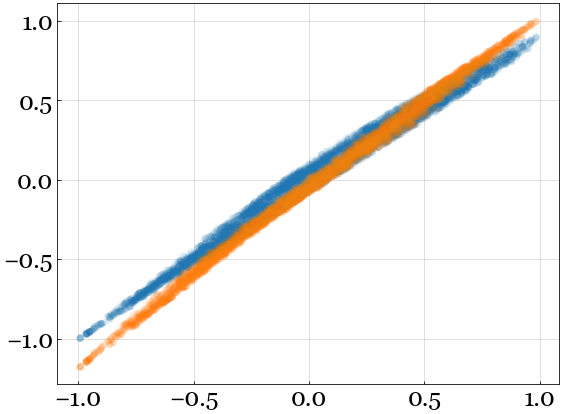

In [16]:
fig=plt.figure()

c0 = (np.cos(th_S1L_r) \
      + qq**2./(1.+qq**2.)/(1.-qq)*S_Mt*chi_eff_v_r/L_v_r * np.cos(th_S1L_r)\
      - 0.5 * qq * S1/(1.-qq)/L_v_r * np.cos(th_S1L_r)**2.\
      + kap_r*np.cos(th_SS_r)) * L_v_r / L_init_r \
    - np.cos(th_S1L_init_r)*( L_v_r / L_init_r - 1.)

c0_ref = (np.cos(th_S1L_r)) * L_v_r / L_init_r \
    - np.cos(th_S1L_init_r)*( L_v_r / L_init_r - 1.)

ax=fig.add_subplot(111)
ax.plot(np.cos(th_S1L_init_r), c0_ref, ls='', marker='.', alpha=0.05)
ax.plot(np.cos(th_S1L_init_r), c0, ls='', marker='.', alpha=0.05)


/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in arccos


500 499


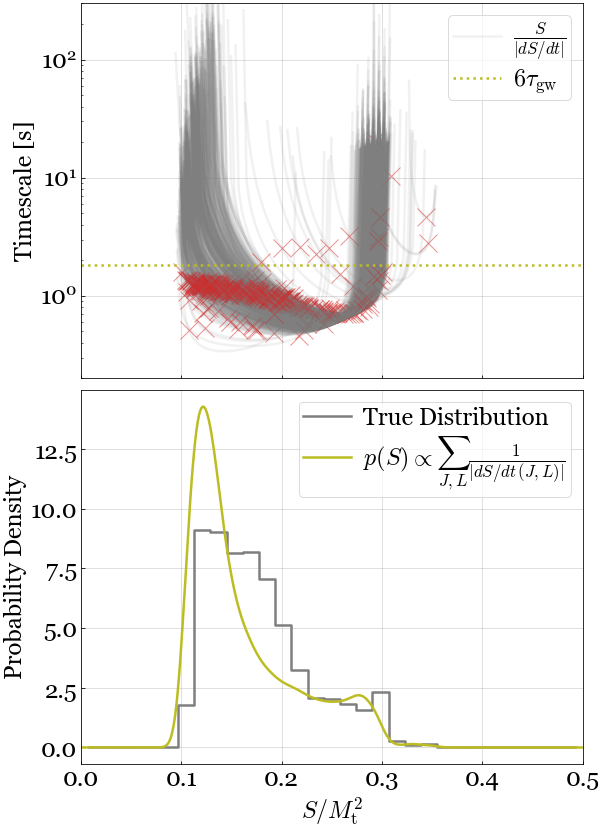

In [8]:
nPt = 50
nPtPDF = 400
nSamp_f = len(J_v_f)

nSamp_f = 500
fig=plt.figure(figsize=(9, 14))
ax=fig.add_subplot(211)

tau_gw = get_inst_t_gw_from_a_orb(M1, M2, 6*r_Mt, 0)

S_pdf_f = np.linspace(0, 0.5, nPtPDF) # in S_Mt
pdf_S_f = np.zeros(nPtPDF)
pdf_S_f_no_cut = np.zeros(nPtPDF)

tau_gw_cut=6.
cnt = 0
for i in range(nSamp_f):
    JJ, LL=J_v_f[i], L_v_f[i]
    ee = 0.

    chi_eff = chi_eff_v_f[i]
#     print(JJ/S_Mt, LL/S_Mt)
    par = np.array([M1, M2, S1, S2, chi_eff])
    
    try:
        S_m, S_p = find_Smp(JJ, LL, ee, par, nPt=nPt)
        SS = np.linspace(S_m, S_p, nPt)
        dSdt = np.zeros(nPt)
    
        tau = get_tau_pre(JJ, LL, ee, par, nPt=nPt)
        for j in range(nPt):
            dSdt[j] = get_dSdt(JJ, LL, ee, SS[j], par)
            
        dSdt_ref = get_dSdt(JJ, LL, ee, S_v_f[i], par)
    
        if cnt==0:
            ax.semilogy(SS/S_Mt, np.abs(SS/dSdt), color='tab:grey', alpha=0.1, label=r'$\frac{S}{|dS/dt|}$')
        else:
            ax.semilogy(SS/S_Mt, np.abs(SS/dSdt), color='tab:grey', alpha=0.1)
        ax.semilogy([S_v_f[i]/S_Mt], [np.abs(S_v_f[i]/dSdt_ref)], color='tab:red', ls='', marker='x', alpha=0.5, ms=18)
        
        idx = np.isfinite(dSdt)
        SS, dSdt = SS[idx], dSdt[idx]
    
        pmf = 1/np.abs(dSdt)
        ### hack the boundaries using extrapolation
        pmf[0]  = 2*pmf[1]-pmf[2] + 0.5*(pmf[3]+pmf[1]-2.*pmf[2]) 
        pmf[-1] = 2*pmf[-2]-pmf[-3] + 0.5*(pmf[-4]+pmf[-2]-2.*pmf[-3]) 
        
        # no cut
        pdf_S_ = pmf/integ.trapz(pmf, SS/S_Mt)
        pdf_vs_S = interp.interp1d(SS/S_Mt, pdf_S_, bounds_error=False, fill_value=0)
    
        pdf_S_ = pdf_vs_S(S_pdf_f)
        pdf_S_f_no_cut += pdf_S_

        # cut based on tau_gw
        idx = np.abs(SS/dSdt) > (tau_gw_cut*tau_gw)
#         pmf[idx] *= 0.
        pmf[idx] = np.ones_like(pmf[idx]) * tau_gw/SS[idx]
    
        pdf_S_ = pmf/integ.trapz(pmf, SS/S_Mt)
        pdf_vs_S = interp.interp1d(SS/S_Mt, pdf_S_, bounds_error=False, fill_value=0)
    
        pdf_S_ = pdf_vs_S(S_pdf_f)
        pdf_S_f += pdf_S_
        cnt += 1
        
    except ValueError:
        continue

pdf_S_f_no_cut/=cnt
pdf_S_f/=cnt

print(nSamp_f, cnt)
    
ax.axhline(tau_gw_cut*tau_gw, ls=':', color='tab:olive', label=r'$%.0f\tau_{\rm gw}$'%tau_gw_cut)
ax.set_xlim([0., 0.5])
ax.set_ylim([0.2, 3.e2])
ax.set_ylabel(r'Timescale [s]')
ax.legend(loc='upper right')
ax.xaxis.set_ticklabels([])

h_SS, edges = np.histogram(S_v_f/S_Mt, bins=31, range=(0, 0.5), density=True)
mid = (edges[1:] + edges[:-1])/2.
ax=fig.add_subplot(212)
ax.step(mid, h_SS, where='mid', color='tab:grey', label=r'True Distribution')
ax.plot(S_pdf_f, g_filt(pdf_S_f_no_cut, 5), color='tab:olive', label=r'$p(S) \propto \sum_{J, L} \frac{1}{|dS/dt\,(J, L)|}$')
ax.legend(loc='upper right')
ax.set_xlim([0., 0.5])
ax.set_ylabel(r'Probability Density')
ax.set_xlabel(r'$S/M_{\rm t}^2$')
plt.subplots_adjust(hspace=0.03)
# plt.savefig(fig_dir_f + 'S_dist_isco.pdf')

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in arccos
/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in double_scalars


800 692


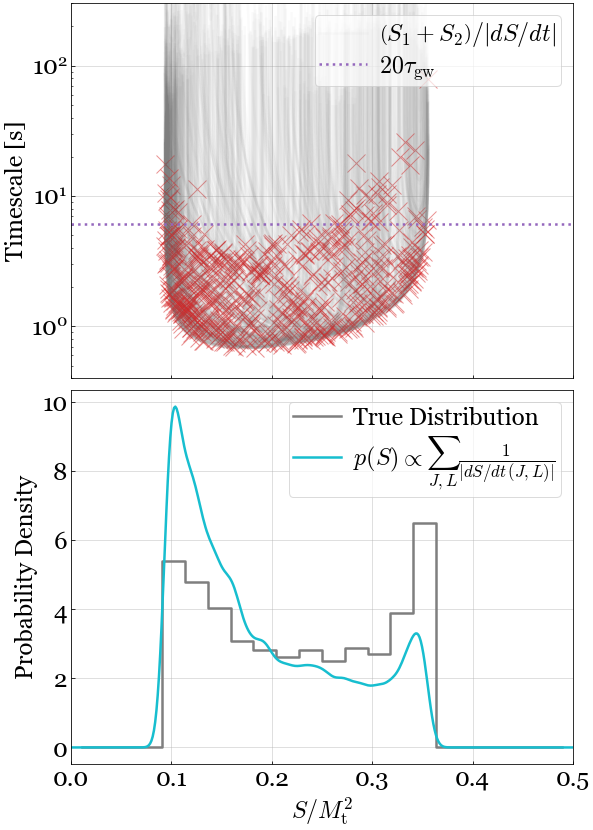

In [7]:
nPt = 400
nPtPDF = 400
nSamp_r = len(J_v_r)

nSamp_r = 800
fig=plt.figure(figsize=(9, 14))
ax=fig.add_subplot(211)

tau_gw = get_inst_t_gw_from_a_orb(M1, M2, 6*r_Mt, 0)

S_pdf_r = np.linspace(0, 0.5, nPtPDF) # in S_Mt
pdf_S_r = np.zeros(nPtPDF)
pdf_S_r_no_cut = np.zeros(nPtPDF)

tau_gw_cut=20.
cnt = 0
for i in range(nSamp_r):
    JJ, LL=J_v_r[i], L_v_r[i]
    ee = 0.

    chi_eff = chi_eff_v_r[i]
#     print(JJ/S_Mt, LL/S_Mt)
    par = np.array([M1, M2, S1, S2, chi_eff])
    
    try:
        S_m, S_p = find_Smp(JJ, LL, ee, par, nPt=nPt)
        SS = np.linspace(S_m, S_p, nPt)
        dSdt = np.zeros(nPt)
    
        tau = get_tau_pre(JJ, LL, ee, par, nPt=nPt)
        for j in range(nPt):
            dSdt[j] = get_dSdt(JJ, LL, ee, SS[j], par)
            
        dSdt_ref = get_dSdt(JJ, LL, ee, S_v_r[i], par)
    
        if cnt==0:
            ax.semilogy(SS/S_Mt, np.abs((S1+S2)/dSdt), color='tab:grey', alpha=0.03, \
                        label=r'${\left(S_1+S_2\right)}/{|dS/dt|}$')
        else:
            ax.semilogy(SS/S_Mt, np.abs((S1+S2)/dSdt), color='tab:grey', alpha=0.03)
        ax.semilogy([S_v_r[i]/S_Mt], [np.abs((S1+S2)/dSdt_ref)], color='tab:red', ls='', marker='x', alpha=0.5, ms=18)
        
        idx = np.isfinite(dSdt)
        SS, dSdt = SS[idx], dSdt[idx]
    
        pmf = 1/np.abs(dSdt)
        ### hack the boundaries using extrapolation
        pmf[0]  = 2*pmf[1]-pmf[2] + 0.5*(pmf[3]+pmf[1]-2.*pmf[2]) 
        pmf[-1] = 2*pmf[-2]-pmf[-3] + 0.5*(pmf[-4]+pmf[-2]-2.*pmf[-3]) 
        
        # no cut
        pdf_S_ = pmf/integ.trapz(pmf, SS/S_Mt)
        pdf_vs_S = interp.interp1d(SS/S_Mt, pdf_S_, bounds_error=False, fill_value=0)
    
        pdf_S_ = pdf_vs_S(S_pdf_r)
        pdf_S_r_no_cut += pdf_S_

        # cut based on tau_gw
        idx = np.abs((S1+S2)/dSdt) > (tau_gw_cut*tau_gw)
        pmf[idx] *= 0.
        pmf[idx] = np.ones_like(pmf[idx]) * tau_gw_cut*tau_gw/(S1+S2)
    
        pdf_S_ = pmf/integ.trapz(pmf, SS/S_Mt)
        pdf_vs_S = interp.interp1d(SS/S_Mt, pdf_S_, bounds_error=False, fill_value=0)
    
        pdf_S_ = pdf_vs_S(S_pdf_r)
        pdf_S_r += pdf_S_
        cnt += 1
        
    except ValueError:
        continue

pdf_S_r_no_cut/=cnt
pdf_S_r/=cnt

print(nSamp_r, cnt)
    
ax.axhline(tau_gw_cut*tau_gw, ls=':', color='tab:purple', label=r'$%.0f\tau_{\rm gw}$'%tau_gw_cut)
ax.set_xlim([0., 0.5])
ax.set_ylim([0.4, 3.e2])
ax.set_ylabel(r'Timescale [s]')
ax.legend(loc='upper right')
ax.xaxis.set_ticklabels([])

h_SS, edges = np.histogram(S_v_r/S_Mt, bins=22, range=(0, 0.5), density=True)
mid = (edges[1:] + edges[:-1])/2.
ax=fig.add_subplot(212)
ax.step(mid, h_SS, where='mid', color='tab:grey', label=r'True Distribution')
ax.plot(S_pdf_r, g_filt(pdf_S_r_no_cut, 5), color='tab:cyan', label=r'$p(S) \propto \sum_{J, L} \frac{1}{|dS/dt\,(J, L)|}$')
# ax.plot(S_pdf_r, g_filt(pdf_S_r, 5), color='tab:cyan', label=r'$p(S) \propto \sum_{J, L} \frac{1}{|dS/dt\,(J, L)|}$')
ax.legend(loc='upper right')
ax.set_xlim([0., 0.5])
ax.set_ylabel(r'Probability Density')
ax.set_xlabel(r'$S/M_{\rm t}^2$')
plt.subplots_adjust(hspace=0.03)
plt.savefig(fig_dir_r + 'S_dist_isco.pdf')

(4001, 3) (8000, 3)


Text(0.5, 0, '$\\theta_{S_1S_2}$ [$^\\circ$]')

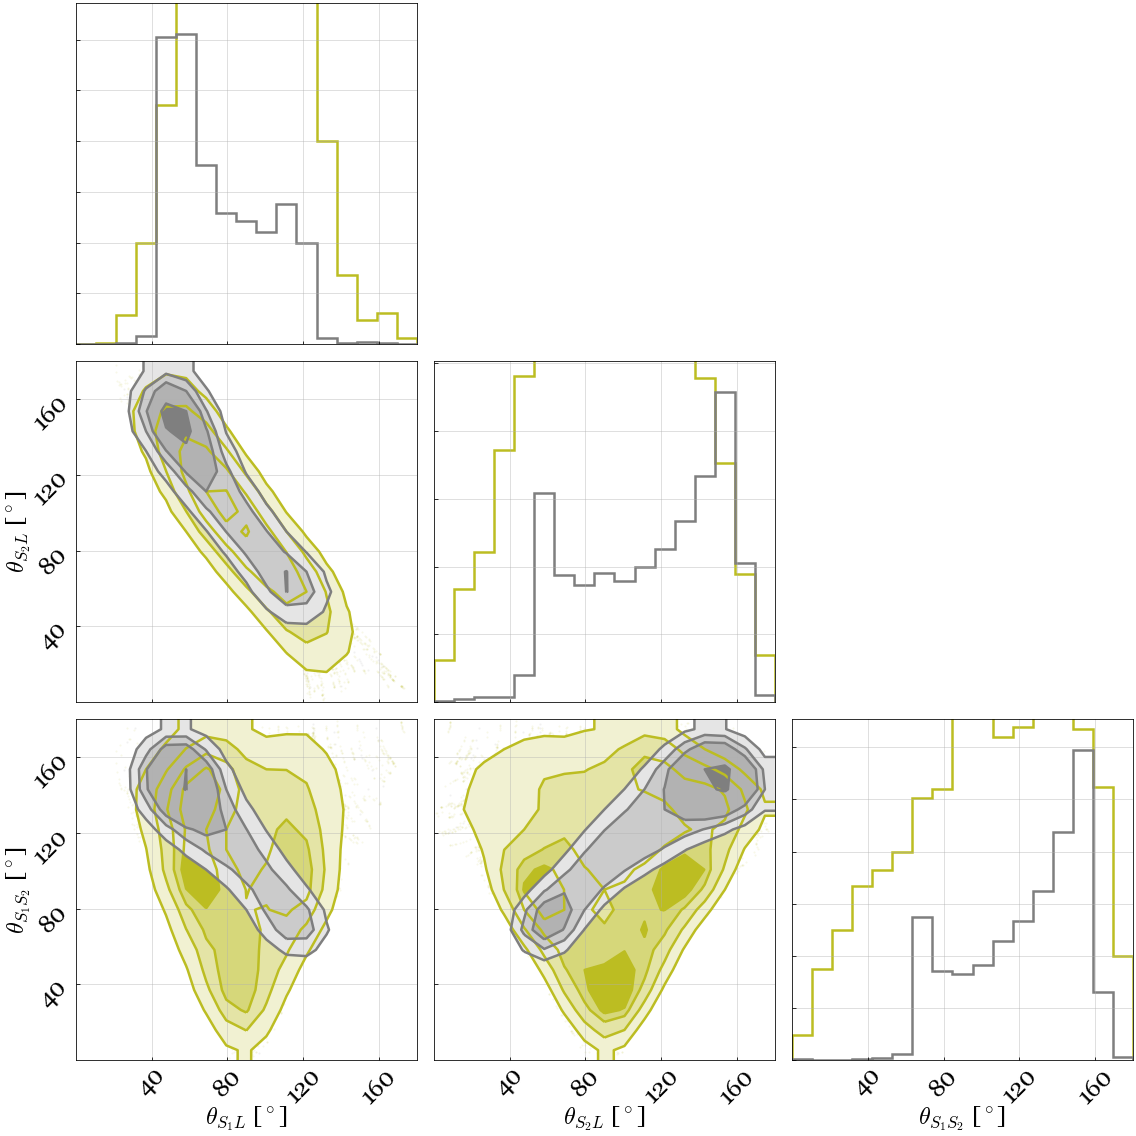

In [7]:
th_dist_f = np.vstack([th_S1L_f*180./np.pi, th_S2L_f*180./np.pi, th_SS_f*180./np.pi]).T
th_dist_r = np.vstack([th_S1L_r*180./np.pi, th_S2L_r*180./np.pi, th_SS_r*180./np.pi]).T
print(th_dist_f.shape, th_dist_r.shape)

nSamp_f = th_dist_f.shape[0]
nSamp_r = th_dist_r.shape[0]

fig, axes=plt.subplots(3, 3, figsize=(18, 18))

fig=corner.corner(th_dist_r, fig=fig, bins=17, 
        color='tab:olive', ls=2.5, 
        labels_kwargs={'pad':-30, 'labelpad':-30},
        range=[(0, 180), (0, 180), (0, 180)], 
        show_titles=False, plot_contours=True, fill_contours=True,
        smooth=1, 
        hist_kwargs={'lw':2.5})

fig = corner.corner(th_dist_f, fig=fig, bins=17,
        color='tab:grey', ls=2.5, weights=np.ones(nSamp_f)*0.7,
        labels_kwargs={'pad':-30, 'labelpad':-30},
        range=[(0, 180), (0, 180), (0, 180)], 
        show_titles=False, plot_contours=True, fill_contours=True,
        smooth=1, 
        hist_kwargs={'lw':2.5})



axes[1, 0].set_ylabel(r'$\theta_{S_2L}$ [$^\circ$]', labelpad=-4)
axes[2, 0].set_ylabel(r'$\theta_{S_1S_2}$ [$^\circ$]', labelpad=-4)
axes[2, 0].set_xlabel(r'$\theta_{S_1L}$ [$^\circ$]', labelpad=-4)
axes[2, 1].set_xlabel(r'$\theta_{S_2L}$ [$^\circ$]', labelpad=-4)
axes[2, 2].set_xlabel(r'$\theta_{S_1S_2}$ [$^\circ$]', labelpad=-4)
# plt.savefig(fig_dir_r+'ang_dist_isco.pdf')

150.0 0.7 0.7
-0.23080667787568662
0.13144444444444445 0.5429864253393664
kap 0.928764861841601


/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in arccos


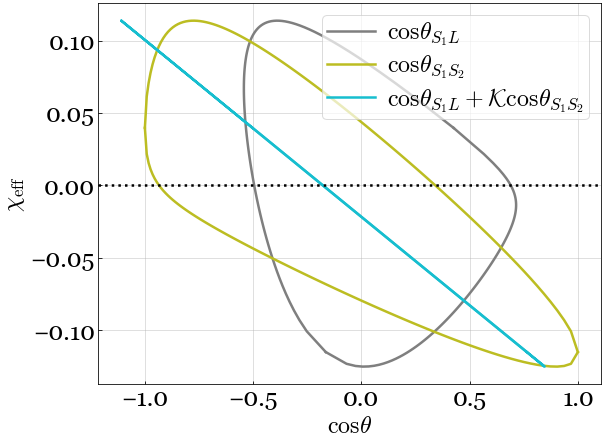

In [10]:
M1, M2 = 85*Ms, 65*Ms
chi1, chi2= 0.7, 0.7
S1, S2 = chi1*G*M1**2./c, chi2*G*M2**2./c
chi_eff=0

Mt=M1+M2
qq = M2/M1
mu=M1*M2/Mt
r_Mt = G*(M1+M2)/c**2.
S_Mt = G*(M1+M2)**2./c
print(Mt/Ms, chi1, chi2)

JJ, LL, SS = \
    0.646758*S_Mt, 0.6014858139456225*S_Mt, 0.22118749999999998*S_Mt

print((JJ**2.-LL**2.-S1**2.-S2**2.)/SS**2.)
print(S2/S_Mt, (1-qq**2.)/qq)

kap = S2/((1-qq)*LL)
print('kap', kap)

nPt = 100
par = np.array([M1, M2, S1, S2, chi_eff])
S_m, S_p = find_Smp(JJ, LL, 0., par, nPt=nPt)
S_v = np.linspace(S_m, S_p, nPt)

S_plot, chi_plot1, chi_plot2 = find_S_chi_contour(JJ, LL, 0., par, nPt=nPt)

th_S1L_plot1, th_S2L_plot1, th_SS_plot1 = np.zeros(nPt), np.zeros(nPt), np.zeros(nPt)
th_S1L_plot2, th_S2L_plot2, th_SS_plot2 = np.zeros(nPt), np.zeros(nPt), np.zeros(nPt)

for i in range(nPt):
    par_1 = np.array([M1, M2, S1, S2, chi_plot1[i]])
    th_S1L_plot1[i], th_S2L_plot1[i], th_SS_plot1[i], __ = \
        get_angles(JJ, LL, 0., S_plot[i], par_1)
    
    par_2 = np.array([M1, M2, S1, S2, chi_plot2[i]])
    th_S1L_plot2[i], th_S2L_plot2[i], th_SS_plot2[i], __ = \
        get_angles(JJ, LL, 0., S_plot[i], par_2)


fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(np.cos(th_S1L_plot1), chi_plot1, color='tab:grey', label=r'$\cos \theta_{S_1L}$')
ax.plot(np.cos(th_S1L_plot2), chi_plot2, color='tab:grey')

ax.plot(np.cos(th_SS_plot1), chi_plot1, color='tab:olive', label=r'$\cos \theta_{S_1S_2}$')
ax.plot(np.cos(th_SS_plot2), chi_plot2, color='tab:olive')

ax.plot((kap*np.cos(th_SS_plot1)+np.cos(th_S1L_plot1)), chi_plot1, color='tab:cyan', label=r'$\cos \theta_{S_1 L }+\mathcal{K}\cos\theta_{S_1S_2}$')
ax.plot((kap*np.cos(th_SS_plot2)+np.cos(th_S1L_plot2)), chi_plot2, color='tab:cyan')

ax.axhline(chi_eff, color='k', ls=':')
ax.set_ylabel(r'$\chi_{\rm eff}$')
ax.set_xlabel(r'$\cos \theta$')
ax.legend()
plt.savefig(fig_dir_r+'eff_potential.pdf')

Text(0, 0.5, 'Probability Density')

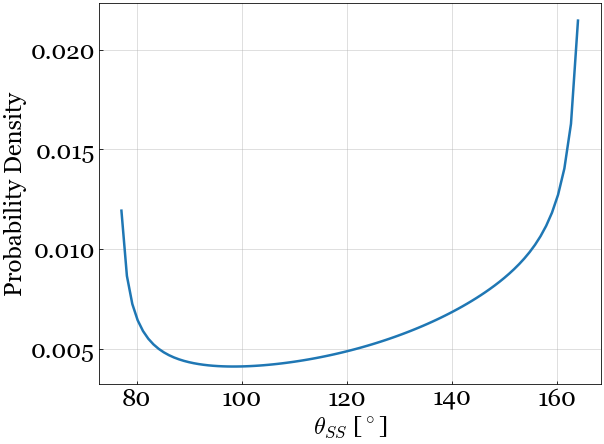

In [12]:
dSdt = np.zeros(nPt)
th1, th2, th12, dphi = np.zeros(nPt), np.zeros(nPt), np.zeros(nPt), np.zeros(nPt)
for i in range(nPt):
    dSdt[i] = get_dSdt(JJ, LL, 0, S_v[i], par)
    th1[i], th2[i], th12[i], dphi[i]=\
        get_angles(JJ, LL, 0, S_v[i], par)
    
tau_pre = get_tau_pre(JJ, LL, 0, par)

prob = np.abs(S_v/dSdt/tau_pre)
prob /= np.sum(prob)

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(th12[1:-1]*180./np.pi, (prob/np.abs(np.gradient(th12*180./np.pi)))[1:-1])
ax.set_xlabel(r'$\theta_{SS}$ [$^\circ$]')
ax.set_ylabel(r'Probability Density')

Text(0, 0.5, 'Probability Density')

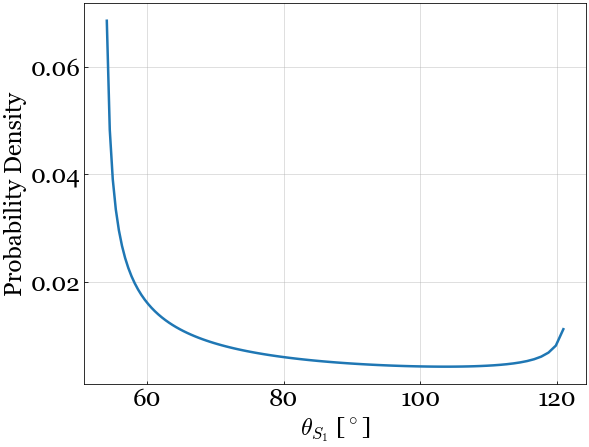

In [14]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(th1[1:-1]*180./np.pi, (prob/np.abs(np.gradient(th1*180./np.pi)))[1:-1])
ax.set_xlabel(r'$\theta_{S_1}$ [$^\circ$]')
ax.set_ylabel(r'Probability Density')

In [28]:
test = np.array([0, 1, 1./0.])
np.isnan(test)

ZeroDivisionError: float division by zero

In [30]:
(85.*np.cos(100.*np.pi/180.) + 25*np.cos(54*np.pi/180.))/(110.)

-0.0005951254034295255

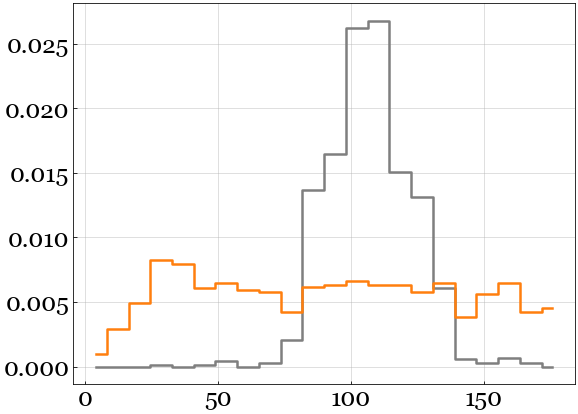

In [5]:
fid = '/home/hang.yu/public_html/astro/LK_evol/LK2merger/fix_init_spin_ang/bin2merg/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/chi_eff_0/spin_data/spin_data_ISCO.h5'
fid = h5.File(fid, 'r')
chi1x, chi1y, chi1z = fid['chi1x'][()], fid['chi1y'][()], fid['chi1z'][()]
chi2x, chi2y, chi2z = fid['chi2x'][()], fid['chi2y'][()], fid['chi2z'][()]
fid.close()

fid = '/home/hang.yu/public_html/astro/LK_evol/LK2merger/fix_init_spin_ang/bin2merg/M3_1.0e+09Ms_ao_0.060pc_ai0_3.0AU/chi_eff_0/spin_data/spin_data_ISCO_uniform_phi12.h5'
fid = h5.File(fid, 'r')
chi3x, chi3y, chi3z = fid['chi2x'][()], fid['chi2y'][()], fid['chi2z'][()]
fid.close()

c_th_12 = (chi1x*chi2x + chi1y*chi2y + chi1z*chi2z)/(0.7*0.7)
th_12 = np.arccos(c_th_12)

c_th_13 = (chi1x*chi3x + chi1y*chi3y + chi1z*chi3z)/(0.7*0.7)
th_13 = np.arccos(c_th_13)

phi_12 = (chi1x*chi2x + chi1y*chi2y)/np.sqrt((chi1x**2.+chi1y**2.)*(chi2x**2.+chi2y**2.))
phi_12 = np.arccos(phi_12)

phi_13 = (chi1x*chi3x + chi1y*chi3y)/np.sqrt((chi1x**2.+chi1y**2.)*(chi3x**2.+chi3y**2.))
phi_13 = np.arccos(phi_13)

nbins=22
h_12, edges = np.histogram(th_12*180./np.pi, bins=nbins, range=(0., 180.), density=True)
h_13, edges = np.histogram(th_13*180./np.pi, bins=nbins, range=(0., 180.), density=True)
mid = 0.5*(edges[1:] + edges[:-1])
fig=plt.figure()
ax=fig.add_subplot(111)
ax.step(mid, h_12, where='mid', color='tab:grey')
ax.step(mid, h_13, where='mid', color='tab:orange')

In [74]:
r_Mt=G*Mt/c**2.
np.sqrt(G*Mt/(100.*r_Mt)**3.)/np.pi

0.4308159300918697

In [10]:
1./(0.12*P_yr)

2.6406739845024126e-07

In [78]:
np.floor(1186736418/64.)*64
print(np.ceil((1186736418+3*3600)/64)*64)

1186747264.0


In [27]:
Mt=150.*Ms
r_Mt = G*Mt/c**2.
300.*r_Mt/AU

0.00044418995979042747

In [17]:
th1 = 75.*np.pi/180.
th2 = 110.*np.pi/180.
(85.*np.cos(th1) + 65*np.cos(th2))/150

-0.0015446032163613666

In [5]:
np.random.uniform(0)

0.27666673244333395

In [17]:
stats.uniform().rvs()

0.3994440553329769

In [55]:
1./3600.

0.0002777777777777778